# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [3]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [4]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [39]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Helper method (from fast.ai)

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [6]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

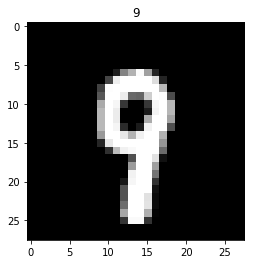

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [7]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [8]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [9]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

In [68]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(10.97, 2.3311052452087404)

In [69]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.5903
Epoch [1/2], Loss: 0.4435
Epoch [1/2], Loss: 0.3813
Epoch [1/2], Loss: 0.3549
Epoch [1/2], Loss: 0.3307
Epoch [1/2], Loss: 0.3105
Epoch [1/2], Loss: 0.3000
Epoch [1/2], Loss: 0.2918
Epoch [1/2], Loss: 0.2849
Epoch [1/2], Loss: 0.2816
Epoch [1/2], Valid Accuracy: 94.0700, Valid Loss: 0.2197
Epoch [2/2], Loss: 0.1963
Epoch [2/2], Loss: 0.2036
Epoch [2/2], Loss: 0.2154
Epoch [2/2], Loss: 0.2133
Epoch [2/2], Loss: 0.2125
Epoch [2/2], Loss: 0.2174
Epoch [2/2], Loss: 0.2184
Epoch [2/2], Loss: 0.2197
Epoch [2/2], Loss: 0.2183
Epoch [2/2], Loss: 0.2193
Epoch [2/2], Valid Accuracy: 94.3000, Valid Loss: 0.2184


(94.3, 0.21835423595905304, 0.21927406187057494)

#### 3. Neural networks for handwritten digit recognition

##### 1) Report a table of validation accuracy for the following values of learning rate 1, 0.1, 0.01, 0.001, 0.0001, 0.00001. Interpolate between the best two values. Train for nb epoch = 10.

In [21]:
learning_rate=[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
results=[]
for i in learning_rate:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=i)
    print ('learning_rate: %s'%i)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results.append([i,val_acc])

learning_rate: 1
Epoch [1/10], Loss: 641.9890
Epoch [1/10], Loss: 322.6749
Epoch [1/10], Loss: 216.0298
Epoch [1/10], Loss: 164.2571
Epoch [1/10], Loss: 133.0490
Epoch [1/10], Loss: 111.8748
Epoch [1/10], Loss: 96.3558
Epoch [1/10], Loss: 85.0192
Epoch [1/10], Loss: 76.3089
Epoch [1/10], Loss: 73.4593
Epoch [1/10], Valid Accuracy: 10.3100, Valid Loss: 123.6319
Epoch [2/10], Loss: 3.9317
Epoch [2/10], Loss: 4.0593
Epoch [2/10], Loss: 3.5941
Epoch [2/10], Loss: 3.5392
Epoch [2/10], Loss: 3.6019
Epoch [2/10], Loss: 3.5263
Epoch [2/10], Loss: 3.7556
Epoch [2/10], Loss: 3.5843
Epoch [2/10], Loss: 3.5635
Epoch [2/10], Loss: 3.5159
Epoch [2/10], Valid Accuracy: 10.3000, Valid Loss: 2.3348
Epoch [3/10], Loss: 2.3685
Epoch [3/10], Loss: 2.3685
Epoch [3/10], Loss: 2.3686
Epoch [3/10], Loss: 2.8683
Epoch [3/10], Loss: 2.7710
Epoch [3/10], Loss: 3.1173
Epoch [3/10], Loss: 3.0104
Epoch [3/10], Loss: 2.9453
Epoch [3/10], Loss: 2.8832
Epoch [3/10], Loss: 2.8625
Epoch [3/10], Valid Accuracy: 10.1200, 

Epoch [5/10], Loss: 0.1701
Epoch [5/10], Valid Accuracy: 95.1600, Valid Loss: 0.2237
Epoch [6/10], Loss: 0.1490
Epoch [6/10], Loss: 0.1591
Epoch [6/10], Loss: 0.1554
Epoch [6/10], Loss: 0.1632
Epoch [6/10], Loss: 0.1699
Epoch [6/10], Loss: 0.1691
Epoch [6/10], Loss: 0.1689
Epoch [6/10], Loss: 0.1681
Epoch [6/10], Loss: 0.1675
Epoch [6/10], Loss: 0.1677
Epoch [6/10], Valid Accuracy: 95.0000, Valid Loss: 0.2512
Epoch [7/10], Loss: 0.1257
Epoch [7/10], Loss: 0.1193
Epoch [7/10], Loss: 0.1376
Epoch [7/10], Loss: 0.1413
Epoch [7/10], Loss: 0.1480
Epoch [7/10], Loss: 0.1482
Epoch [7/10], Loss: 0.1540
Epoch [7/10], Loss: 0.1541
Epoch [7/10], Loss: 0.1581
Epoch [7/10], Loss: 0.1587
Epoch [7/10], Valid Accuracy: 94.8900, Valid Loss: 0.2271
Epoch [8/10], Loss: 0.1233
Epoch [8/10], Loss: 0.1370
Epoch [8/10], Loss: 0.1362
Epoch [8/10], Loss: 0.1369
Epoch [8/10], Loss: 0.1398
Epoch [8/10], Loss: 0.1422
Epoch [8/10], Loss: 0.1475
Epoch [8/10], Loss: 0.1494
Epoch [8/10], Loss: 0.1511
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.0632
Epoch [10/10], Loss: 0.0640
Epoch [10/10], Loss: 0.0642
Epoch [10/10], Valid Accuracy: 97.5900, Valid Loss: 0.0819
learning_rate: 1e-05
Epoch [1/10], Loss: 2.2075
Epoch [1/10], Loss: 2.0838
Epoch [1/10], Loss: 1.9686
Epoch [1/10], Loss: 1.8563
Epoch [1/10], Loss: 1.7536
Epoch [1/10], Loss: 1.6601
Epoch [1/10], Loss: 1.5748
Epoch [1/10], Loss: 1.4980
Epoch [1/10], Loss: 1.4302
Epoch [1/10], Loss: 1.4061
Epoch [1/10], Valid Accuracy: 84.7300, Valid Loss: 0.7987
Epoch [2/10], Loss: 0.7931
Epoch [2/10], Loss: 0.7706
Epoch [2/10], Loss: 0.7449
Epoch [2/10], Loss: 0.7215
Epoch [2/10], Loss: 0.7017
Epoch [2/10], Loss: 0.6844
Epoch [2/10], Loss: 0.6681
Epoch [2/10], Loss: 0.6541
Epoch [2/10], Loss: 0.6404
Epoch [2/10], Loss: 0.6353
Epoch [2/10], Valid Accuracy: 88.4200, Valid Loss: 0.4968
Epoch [3/10], Loss: 0.5118
Epoch [3/10], Loss: 0.5081
Epoch [3/10], Loss: 0.5043
Epoch [3/10], Loss: 0.4955
Epoch [3/10], Loss: 0.4872
Epoch [3/10], Loss: 0.4805
Epoch [3/10], Loss

In [34]:
import pandas as pd
pd.DataFrame(data=np.array(results),columns=["learning_rate","val_acc"])

,learning_rate,val_acc
0,1.00000,10.13
1,0.10000,11.58
2,0.01000,95.44
3,0.00100,97.65
4,0.00010,97.59
5,0.00001,92.84


##### Interpolate between the best two values, which are 0.001 with validation accuracy of 97.65% and 0.0001 with validation accuracy of 97.59%.

In [35]:
net = get_model()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
print ('learning_rate: %s'%0.0005)
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)

learning_rate: 0.0005
Epoch [1/10], Loss: 0.6989
Epoch [1/10], Loss: 0.5167
Epoch [1/10], Loss: 0.4310
Epoch [1/10], Loss: 0.3844
Epoch [1/10], Loss: 0.3500
Epoch [1/10], Loss: 0.3228
Epoch [1/10], Loss: 0.3038
Epoch [1/10], Loss: 0.2878
Epoch [1/10], Loss: 0.2725
Epoch [1/10], Loss: 0.2671
Epoch [1/10], Valid Accuracy: 95.5000, Valid Loss: 0.1463
Epoch [2/10], Loss: 0.1232
Epoch [2/10], Loss: 0.1264
Epoch [2/10], Loss: 0.1233
Epoch [2/10], Loss: 0.1220
Epoch [2/10], Loss: 0.1212
Epoch [2/10], Loss: 0.1182
Epoch [2/10], Loss: 0.1168
Epoch [2/10], Loss: 0.1130
Epoch [2/10], Loss: 0.1106
Epoch [2/10], Loss: 0.1099
Epoch [2/10], Valid Accuracy: 97.0500, Valid Loss: 0.0944
Epoch [3/10], Loss: 0.0725
Epoch [3/10], Loss: 0.0739
Epoch [3/10], Loss: 0.0745
Epoch [3/10], Loss: 0.0735
Epoch [3/10], Loss: 0.0729
Epoch [3/10], Loss: 0.0734
Epoch [3/10], Loss: 0.0744
Epoch [3/10], Loss: 0.0734
Epoch [3/10], Loss: 0.0734
Epoch [3/10], Loss: 0.0729
Epoch [3/10], Valid Accuracy: 97.6700, Valid Loss: 0

In [36]:
val_acc

98.04

##### 2) Examine how the size of a hidden layer affect the model’s performance. Which hidden layer size parameter achieves the best performance? Are some of these model overfitting? How can you tell that?

In [37]:
results2=[]
M=[10, 50, 100, 300, 1000, 2000]
for m in M:
    net = get_model(M=m)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    print ('hidden layer size: %s'%m)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results2.append([m,train_loss,val_loss,val_acc])

hidden layer size: 10
Epoch [1/10], Loss: 0.6708
Epoch [1/10], Loss: 0.5530
Epoch [1/10], Loss: 0.4968
Epoch [1/10], Loss: 0.4707
Epoch [1/10], Loss: 0.4521
Epoch [1/10], Loss: 0.4391
Epoch [1/10], Loss: 0.4266
Epoch [1/10], Loss: 0.4186
Epoch [1/10], Loss: 0.4119
Epoch [1/10], Loss: 0.4089
Epoch [1/10], Valid Accuracy: 89.7000, Valid Loss: 0.3474
Epoch [2/10], Loss: 0.3231
Epoch [2/10], Loss: 0.3119
Epoch [2/10], Loss: 0.3131
Epoch [2/10], Loss: 0.3184
Epoch [2/10], Loss: 0.3157
Epoch [2/10], Loss: 0.3174
Epoch [2/10], Loss: 0.3191
Epoch [2/10], Loss: 0.3224
Epoch [2/10], Loss: 0.3221
Epoch [2/10], Loss: 0.3227
Epoch [2/10], Valid Accuracy: 90.6500, Valid Loss: 0.3189
Epoch [3/10], Loss: 0.3046
Epoch [3/10], Loss: 0.3045
Epoch [3/10], Loss: 0.3041
Epoch [3/10], Loss: 0.3087
Epoch [3/10], Loss: 0.3105
Epoch [3/10], Loss: 0.3084
Epoch [3/10], Loss: 0.3061
Epoch [3/10], Loss: 0.3056
Epoch [3/10], Loss: 0.3073
Epoch [3/10], Loss: 0.3067
Epoch [3/10], Valid Accuracy: 90.7700, Valid Loss: 0

Epoch [5/10], Loss: 0.1706
Epoch [5/10], Valid Accuracy: 94.9100, Valid Loss: 0.2171
Epoch [6/10], Loss: 0.1425
Epoch [6/10], Loss: 0.1588
Epoch [6/10], Loss: 0.1528
Epoch [6/10], Loss: 0.1569
Epoch [6/10], Loss: 0.1585
Epoch [6/10], Loss: 0.1586
Epoch [6/10], Loss: 0.1598
Epoch [6/10], Loss: 0.1606
Epoch [6/10], Loss: 0.1648
Epoch [6/10], Loss: 0.1655
Epoch [6/10], Valid Accuracy: 94.9200, Valid Loss: 0.2139
Epoch [7/10], Loss: 0.1480
Epoch [7/10], Loss: 0.1618
Epoch [7/10], Loss: 0.1655
Epoch [7/10], Loss: 0.1685
Epoch [7/10], Loss: 0.1684
Epoch [7/10], Loss: 0.1668
Epoch [7/10], Loss: 0.1679
Epoch [7/10], Loss: 0.1658
Epoch [7/10], Loss: 0.1650
Epoch [7/10], Loss: 0.1639
Epoch [7/10], Valid Accuracy: 95.5400, Valid Loss: 0.2242
Epoch [8/10], Loss: 0.1234
Epoch [8/10], Loss: 0.1292
Epoch [8/10], Loss: 0.1367
Epoch [8/10], Loss: 0.1450
Epoch [8/10], Loss: 0.1447
Epoch [8/10], Loss: 0.1490
Epoch [8/10], Loss: 0.1487
Epoch [8/10], Loss: 0.1510
Epoch [8/10], Loss: 0.1518
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.1508
Epoch [10/10], Loss: 0.1514
Epoch [10/10], Loss: 0.1505
Epoch [10/10], Loss: 0.1521
Epoch [10/10], Valid Accuracy: 95.5900, Valid Loss: 0.2434
hidden layer size: 2000
Epoch [1/10], Loss: 1.0388
Epoch [1/10], Loss: 0.6669
Epoch [1/10], Loss: 0.5482
Epoch [1/10], Loss: 0.4731
Epoch [1/10], Loss: 0.4334
Epoch [1/10], Loss: 0.4000
Epoch [1/10], Loss: 0.3807
Epoch [1/10], Loss: 0.3629
Epoch [1/10], Loss: 0.3510
Epoch [1/10], Loss: 0.3468
Epoch [1/10], Valid Accuracy: 94.1200, Valid Loss: 0.2179
Epoch [2/10], Loss: 0.2262
Epoch [2/10], Loss: 0.2190
Epoch [2/10], Loss: 0.2115
Epoch [2/10], Loss: 0.2053
Epoch [2/10], Loss: 0.2029
Epoch [2/10], Loss: 0.2069
Epoch [2/10], Loss: 0.2077
Epoch [2/10], Loss: 0.2069
Epoch [2/10], Loss: 0.2102
Epoch [2/10], Loss: 0.2129
Epoch [2/10], Valid Accuracy: 94.4000, Valid Loss: 0.2256
Epoch [3/10], Loss: 0.1967
Epoch [3/10], Loss: 0.2094
Epoch [3/10], Loss: 0.2053
Epoch [3/10], Loss: 0.2077
Epoch [3/10], Loss: 0.2064
Epoch [3/10], 

In [38]:
pd.DataFrame(data=np.array(results2),columns=["M",'train_loss','val_loss','val_acc'])

,M,train_loss,val_loss,val_acc
0,10.0,0.285491,0.321106,91.29
1,50.0,0.166647,0.277266,94.37
2,100.0,0.154545,0.222566,95.65
3,300.0,0.148229,0.233162,95.26
4,1000.0,0.152059,0.243412,95.59
5,2000.0,0.146476,0.241770,95.40


Hidden layer size 100 achieves the best performance. Most of the models overfits, because the train loss are much lower than validation loss.

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [39]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

##### 3) Train a neural network that employs L2 weight decay and compare it with the network without regularization. Report the train loss, validation loss and validation accuracy.

In [40]:
weight_decay=[0, 0.0001, 0.001, 0.01, 0.1, 0.3]
results3=[]

for w in weight_decay:
    net = get_model(M = 300)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=w)
    print ('weight_decay: %s'%w)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    results3.append([w,train_loss,val_loss,val_acc])

weight_decay: 0
Epoch [1/20], Loss: 0.5503
Epoch [1/20], Loss: 0.4158
Epoch [1/20], Loss: 0.3599
Epoch [1/20], Loss: 0.3184
Epoch [1/20], Loss: 0.2943
Epoch [1/20], Loss: 0.2735
Epoch [1/20], Loss: 0.2538
Epoch [1/20], Loss: 0.2377
Epoch [1/20], Loss: 0.2250
Epoch [1/20], Loss: 0.2202
Epoch [1/20], Valid Accuracy: 96.8600, Valid Loss: 0.1050
Epoch [2/20], Loss: 0.1107
Epoch [2/20], Loss: 0.1021
Epoch [2/20], Loss: 0.0992
Epoch [2/20], Loss: 0.0981
Epoch [2/20], Loss: 0.0939
Epoch [2/20], Loss: 0.0946
Epoch [2/20], Loss: 0.0943
Epoch [2/20], Loss: 0.0924
Epoch [2/20], Loss: 0.0922
Epoch [2/20], Loss: 0.0912
Epoch [2/20], Valid Accuracy: 97.2400, Valid Loss: 0.0871
Epoch [3/20], Loss: 0.0680
Epoch [3/20], Loss: 0.0630
Epoch [3/20], Loss: 0.0626
Epoch [3/20], Loss: 0.0609
Epoch [3/20], Loss: 0.0589
Epoch [3/20], Loss: 0.0594
Epoch [3/20], Loss: 0.0602
Epoch [3/20], Loss: 0.0607
Epoch [3/20], Loss: 0.0619
Epoch [3/20], Loss: 0.0625
Epoch [3/20], Valid Accuracy: 97.6300, Valid Loss: 0.0745


Epoch [5/20], Loss: 0.0388
Epoch [5/20], Loss: 0.0398
Epoch [5/20], Loss: 0.0403
Epoch [5/20], Valid Accuracy: 97.3800, Valid Loss: 0.0851
Epoch [6/20], Loss: 0.0293
Epoch [6/20], Loss: 0.0284
Epoch [6/20], Loss: 0.0284
Epoch [6/20], Loss: 0.0294
Epoch [6/20], Loss: 0.0295
Epoch [6/20], Loss: 0.0309
Epoch [6/20], Loss: 0.0322
Epoch [6/20], Loss: 0.0328
Epoch [6/20], Loss: 0.0347
Epoch [6/20], Loss: 0.0350
Epoch [6/20], Valid Accuracy: 97.6700, Valid Loss: 0.0789
Epoch [7/20], Loss: 0.0222
Epoch [7/20], Loss: 0.0206
Epoch [7/20], Loss: 0.0213
Epoch [7/20], Loss: 0.0217
Epoch [7/20], Loss: 0.0237
Epoch [7/20], Loss: 0.0242
Epoch [7/20], Loss: 0.0259
Epoch [7/20], Loss: 0.0275
Epoch [7/20], Loss: 0.0286
Epoch [7/20], Loss: 0.0289
Epoch [7/20], Valid Accuracy: 97.7200, Valid Loss: 0.0826
Epoch [8/20], Loss: 0.0220
Epoch [8/20], Loss: 0.0210
Epoch [8/20], Loss: 0.0214
Epoch [8/20], Loss: 0.0235
Epoch [8/20], Loss: 0.0255
Epoch [8/20], Loss: 0.0275
Epoch [8/20], Loss: 0.0271
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0514
Epoch [10/20], Loss: 0.0541
Epoch [10/20], Loss: 0.0560
Epoch [10/20], Loss: 0.0581
Epoch [10/20], Loss: 0.0580
Epoch [10/20], Loss: 0.0579
Epoch [10/20], Loss: 0.0587
Epoch [10/20], Loss: 0.0588
Epoch [10/20], Valid Accuracy: 97.5500, Valid Loss: 0.0796
Epoch [11/20], Loss: 0.0543
Epoch [11/20], Loss: 0.0526
Epoch [11/20], Loss: 0.0565
Epoch [11/20], Loss: 0.0552
Epoch [11/20], Loss: 0.0538
Epoch [11/20], Loss: 0.0543
Epoch [11/20], Loss: 0.0550
Epoch [11/20], Loss: 0.0560
Epoch [11/20], Loss: 0.0570
Epoch [11/20], Loss: 0.0572
Epoch [11/20], Valid Accuracy: 97.4800, Valid Loss: 0.0839
Epoch [12/20], Loss: 0.0479
Epoch [12/20], Loss: 0.0508
Epoch [12/20], Loss: 0.0519
Epoch [12/20], Loss: 0.0519
Epoch [12/20], Loss: 0.0537
Epoch [12/20], Loss: 0.0541
Epoch [12/20], Loss: 0.0536
Epoch [12/20], Loss: 0.0540
Epoch [12/20], Loss: 0.0545
Epoch [12/20], Loss: 0.0544
Epoch [12/20], Valid Accuracy: 97.5700, Valid Loss: 0.0759
Epoch [13/20], Loss: 0.0525
Epoch [13/2

Epoch [14/20], Loss: 0.1590
Epoch [14/20], Loss: 0.1594
Epoch [14/20], Loss: 0.1591
Epoch [14/20], Valid Accuracy: 96.2800, Valid Loss: 0.1445
Epoch [15/20], Loss: 0.1561
Epoch [15/20], Loss: 0.1537
Epoch [15/20], Loss: 0.1563
Epoch [15/20], Loss: 0.1563
Epoch [15/20], Loss: 0.1567
Epoch [15/20], Loss: 0.1565
Epoch [15/20], Loss: 0.1572
Epoch [15/20], Loss: 0.1578
Epoch [15/20], Loss: 0.1578
Epoch [15/20], Loss: 0.1580
Epoch [15/20], Valid Accuracy: 96.2000, Valid Loss: 0.1488
Epoch [16/20], Loss: 0.1447
Epoch [16/20], Loss: 0.1466
Epoch [16/20], Loss: 0.1493
Epoch [16/20], Loss: 0.1542
Epoch [16/20], Loss: 0.1532
Epoch [16/20], Loss: 0.1544
Epoch [16/20], Loss: 0.1546
Epoch [16/20], Loss: 0.1551
Epoch [16/20], Loss: 0.1560
Epoch [16/20], Loss: 0.1561
Epoch [16/20], Valid Accuracy: 95.9900, Valid Loss: 0.1500
Epoch [17/20], Loss: 0.1528
Epoch [17/20], Loss: 0.1562
Epoch [17/20], Loss: 0.1550
Epoch [17/20], Loss: 0.1556
Epoch [17/20], Loss: 0.1556
Epoch [17/20], Loss: 0.1562
Epoch [17/2

Epoch [19/20], Loss: 0.4561
Epoch [19/20], Loss: 0.4576
Epoch [19/20], Loss: 0.4583
Epoch [19/20], Loss: 0.4608
Epoch [19/20], Loss: 0.4580
Epoch [19/20], Loss: 0.4610
Epoch [19/20], Loss: 0.4626
Epoch [19/20], Loss: 0.4626
Epoch [19/20], Loss: 0.4606
Epoch [19/20], Loss: 0.4604
Epoch [19/20], Valid Accuracy: 89.9700, Valid Loss: 0.4435
Epoch [20/20], Loss: 0.4667
Epoch [20/20], Loss: 0.4637
Epoch [20/20], Loss: 0.4643
Epoch [20/20], Loss: 0.4647
Epoch [20/20], Loss: 0.4676
Epoch [20/20], Loss: 0.4664
Epoch [20/20], Loss: 0.4636
Epoch [20/20], Loss: 0.4626
Epoch [20/20], Loss: 0.4619
Epoch [20/20], Loss: 0.4612
Epoch [20/20], Valid Accuracy: 89.4600, Valid Loss: 0.4441
weight_decay: 0.3
Epoch [1/20], Loss: 1.0089
Epoch [1/20], Loss: 0.9325
Epoch [1/20], Loss: 0.9007
Epoch [1/20], Loss: 0.8884
Epoch [1/20], Loss: 0.8792
Epoch [1/20], Loss: 0.8730
Epoch [1/20], Loss: 0.8681
Epoch [1/20], Loss: 0.8652
Epoch [1/20], Loss: 0.8629
Epoch [1/20], Loss: 0.8618
Epoch [1/20], Valid Accuracy: 77.6

In [41]:
pd.DataFrame(data=np.array(results3),columns=["weight_decay",'train_loss','val_loss','val_acc'])

,weight_decay,train_loss,val_loss,val_acc
0,0.0000,0.010611,0.115301,98.04
1,0.0001,0.018467,0.081454,97.71
2,0.0010,0.049028,0.066606,97.89
3,0.0100,0.156212,0.155796,95.72
4,0.1000,0.461216,0.444073,89.46
5,0.3000,0.809294,0.796036,84.39


## Models with Dropout

In [10]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [13]:
net2 = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net2.parameters(), lr=0.01)

In [14]:
train_model(train_loader, test_loader, num_epochs=4, model=net2, optimizer=optimizer)

Epoch [1/4], Loss: 0.6006
Epoch [1/4], Loss: 0.4758
Epoch [1/4], Loss: 0.4162
Epoch [1/4], Loss: 0.3948
Epoch [1/4], Loss: 0.3776
Epoch [1/4], Loss: 0.3595
Epoch [1/4], Loss: 0.3506
Epoch [1/4], Loss: 0.3446
Epoch [1/4], Loss: 0.3366
Epoch [1/4], Loss: 0.3349
Epoch [1/4], Valid Accuracy: 93.4700, Valid Loss: 0.2291
Epoch [2/4], Loss: 0.2722
Epoch [2/4], Loss: 0.2546
Epoch [2/4], Loss: 0.2633
Epoch [2/4], Loss: 0.2669
Epoch [2/4], Loss: 0.2720
Epoch [2/4], Loss: 0.2732
Epoch [2/4], Loss: 0.2757
Epoch [2/4], Loss: 0.2754
Epoch [2/4], Loss: 0.2721
Epoch [2/4], Loss: 0.2709
Epoch [2/4], Valid Accuracy: 95.0000, Valid Loss: 0.1839
Epoch [3/4], Loss: 0.2415
Epoch [3/4], Loss: 0.2276
Epoch [3/4], Loss: 0.2257
Epoch [3/4], Loss: 0.2298
Epoch [3/4], Loss: 0.2297
Epoch [3/4], Loss: 0.2342
Epoch [3/4], Loss: 0.2353
Epoch [3/4], Loss: 0.2363
Epoch [3/4], Loss: 0.2362
Epoch [3/4], Loss: 0.2363
Epoch [3/4], Valid Accuracy: 94.2200, Valid Loss: 0.2417
Epoch [4/4], Loss: 0.2546
Epoch [4/4], Loss: 0.24

(92.91, 0.3192074136018753, 0.24409669048984844)

##### 4) Explore how the choice of a dropout parameter affect the performance of the model. Train the model with various dropout parameters ranging for 0 to 1. Report the train loss, validation loss and validation accuracy. Which parameter value achieves the best performance? Why? Does the dropout help to increase testing accuracy compared to the model without a dropout? Compare results with L2 regularization.

In [15]:
dropout_range=np.arange(0,1,0.1)
results4=[]

for p in dropout_range:
    net2 = get_model_v2(M = 300,p=p)
    optimizer = optim.Adam(net2.parameters(), lr=0.001)
    print ('p: %s'%p)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net2, optimizer=optimizer)
    results4.append([p,train_loss,val_loss,val_acc])

p: 0.0
Epoch [1/20], Loss: 0.5564
Epoch [1/20], Loss: 0.4214
Epoch [1/20], Loss: 0.3605
Epoch [1/20], Loss: 0.3198
Epoch [1/20], Loss: 0.2902
Epoch [1/20], Loss: 0.2694
Epoch [1/20], Loss: 0.2511
Epoch [1/20], Loss: 0.2372
Epoch [1/20], Loss: 0.2252
Epoch [1/20], Loss: 0.2206
Epoch [1/20], Valid Accuracy: 96.4900, Valid Loss: 0.1138
Epoch [2/20], Loss: 0.0876
Epoch [2/20], Loss: 0.0897
Epoch [2/20], Loss: 0.0893
Epoch [2/20], Loss: 0.0897
Epoch [2/20], Loss: 0.0913
Epoch [2/20], Loss: 0.0915
Epoch [2/20], Loss: 0.0903
Epoch [2/20], Loss: 0.0902
Epoch [2/20], Loss: 0.0901
Epoch [2/20], Loss: 0.0906
Epoch [2/20], Valid Accuracy: 97.1700, Valid Loss: 0.0863
Epoch [3/20], Loss: 0.0600
Epoch [3/20], Loss: 0.0533
Epoch [3/20], Loss: 0.0575
Epoch [3/20], Loss: 0.0599
Epoch [3/20], Loss: 0.0596
Epoch [3/20], Loss: 0.0609
Epoch [3/20], Loss: 0.0613
Epoch [3/20], Loss: 0.0620
Epoch [3/20], Loss: 0.0614
Epoch [3/20], Loss: 0.0611
Epoch [3/20], Valid Accuracy: 97.6600, Valid Loss: 0.0763
Epoch [4/

Epoch [5/20], Loss: 0.0471
Epoch [5/20], Loss: 0.0465
Epoch [5/20], Loss: 0.0467
Epoch [5/20], Valid Accuracy: 98.0800, Valid Loss: 0.0662
Epoch [6/20], Loss: 0.0392
Epoch [6/20], Loss: 0.0373
Epoch [6/20], Loss: 0.0370
Epoch [6/20], Loss: 0.0371
Epoch [6/20], Loss: 0.0378
Epoch [6/20], Loss: 0.0385
Epoch [6/20], Loss: 0.0385
Epoch [6/20], Loss: 0.0387
Epoch [6/20], Loss: 0.0388
Epoch [6/20], Loss: 0.0387
Epoch [6/20], Valid Accuracy: 97.9200, Valid Loss: 0.0768
Epoch [7/20], Loss: 0.0308
Epoch [7/20], Loss: 0.0292
Epoch [7/20], Loss: 0.0289
Epoch [7/20], Loss: 0.0305
Epoch [7/20], Loss: 0.0312
Epoch [7/20], Loss: 0.0311
Epoch [7/20], Loss: 0.0312
Epoch [7/20], Loss: 0.0314
Epoch [7/20], Loss: 0.0318
Epoch [7/20], Loss: 0.0319
Epoch [7/20], Valid Accuracy: 97.9900, Valid Loss: 0.0731
Epoch [8/20], Loss: 0.0281
Epoch [8/20], Loss: 0.0294
Epoch [8/20], Loss: 0.0308
Epoch [8/20], Loss: 0.0301
Epoch [8/20], Loss: 0.0288
Epoch [8/20], Loss: 0.0295
Epoch [8/20], Loss: 0.0301
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0285
Epoch [10/20], Loss: 0.0296
Epoch [10/20], Loss: 0.0290
Epoch [10/20], Loss: 0.0298
Epoch [10/20], Loss: 0.0312
Epoch [10/20], Loss: 0.0321
Epoch [10/20], Loss: 0.0328
Epoch [10/20], Loss: 0.0327
Epoch [10/20], Valid Accuracy: 98.3400, Valid Loss: 0.0642
Epoch [11/20], Loss: 0.0296
Epoch [11/20], Loss: 0.0265
Epoch [11/20], Loss: 0.0272
Epoch [11/20], Loss: 0.0282
Epoch [11/20], Loss: 0.0283
Epoch [11/20], Loss: 0.0290
Epoch [11/20], Loss: 0.0306
Epoch [11/20], Loss: 0.0307
Epoch [11/20], Loss: 0.0310
Epoch [11/20], Loss: 0.0315
Epoch [11/20], Valid Accuracy: 97.9400, Valid Loss: 0.0823
Epoch [12/20], Loss: 0.0298
Epoch [12/20], Loss: 0.0333
Epoch [12/20], Loss: 0.0328
Epoch [12/20], Loss: 0.0329
Epoch [12/20], Loss: 0.0320
Epoch [12/20], Loss: 0.0318
Epoch [12/20], Loss: 0.0308
Epoch [12/20], Loss: 0.0300
Epoch [12/20], Loss: 0.0311
Epoch [12/20], Loss: 0.0310
Epoch [12/20], Valid Accuracy: 98.1900, Valid Loss: 0.0793
Epoch [13/20], Loss: 0.0247
Epoch [13/2

Epoch [14/20], Loss: 0.0366
Epoch [14/20], Loss: 0.0369
Epoch [14/20], Valid Accuracy: 98.1400, Valid Loss: 0.0783
Epoch [15/20], Loss: 0.0356
Epoch [15/20], Loss: 0.0356
Epoch [15/20], Loss: 0.0349
Epoch [15/20], Loss: 0.0340
Epoch [15/20], Loss: 0.0342
Epoch [15/20], Loss: 0.0357
Epoch [15/20], Loss: 0.0365
Epoch [15/20], Loss: 0.0363
Epoch [15/20], Loss: 0.0369
Epoch [15/20], Loss: 0.0370
Epoch [15/20], Valid Accuracy: 98.1700, Valid Loss: 0.0804
Epoch [16/20], Loss: 0.0310
Epoch [16/20], Loss: 0.0313
Epoch [16/20], Loss: 0.0319
Epoch [16/20], Loss: 0.0336
Epoch [16/20], Loss: 0.0328
Epoch [16/20], Loss: 0.0323
Epoch [16/20], Loss: 0.0330
Epoch [16/20], Loss: 0.0339
Epoch [16/20], Loss: 0.0349
Epoch [16/20], Loss: 0.0352
Epoch [16/20], Valid Accuracy: 98.1400, Valid Loss: 0.0816
Epoch [17/20], Loss: 0.0378
Epoch [17/20], Loss: 0.0360
Epoch [17/20], Loss: 0.0341
Epoch [17/20], Loss: 0.0352
Epoch [17/20], Loss: 0.0356
Epoch [17/20], Loss: 0.0364
Epoch [17/20], Loss: 0.0368
Epoch [17/2

Epoch [19/20], Loss: 0.0411
Epoch [19/20], Loss: 0.0402
Epoch [19/20], Loss: 0.0388
Epoch [19/20], Loss: 0.0401
Epoch [19/20], Loss: 0.0423
Epoch [19/20], Loss: 0.0423
Epoch [19/20], Loss: 0.0431
Epoch [19/20], Loss: 0.0432
Epoch [19/20], Valid Accuracy: 97.9300, Valid Loss: 0.0869
Epoch [20/20], Loss: 0.0360
Epoch [20/20], Loss: 0.0414
Epoch [20/20], Loss: 0.0408
Epoch [20/20], Loss: 0.0407
Epoch [20/20], Loss: 0.0425
Epoch [20/20], Loss: 0.0441
Epoch [20/20], Loss: 0.0436
Epoch [20/20], Loss: 0.0439
Epoch [20/20], Loss: 0.0438
Epoch [20/20], Loss: 0.0442
Epoch [20/20], Valid Accuracy: 98.0000, Valid Loss: 0.0950
p: 0.5
Epoch [1/20], Loss: 0.7026
Epoch [1/20], Loss: 0.5297
Epoch [1/20], Loss: 0.4505
Epoch [1/20], Loss: 0.4071
Epoch [1/20], Loss: 0.3744
Epoch [1/20], Loss: 0.3513
Epoch [1/20], Loss: 0.3318
Epoch [1/20], Loss: 0.3190
Epoch [1/20], Loss: 0.3054
Epoch [1/20], Loss: 0.3001
Epoch [1/20], Valid Accuracy: 96.0500, Valid Loss: 0.1287
Epoch [2/20], Loss: 0.1849
Epoch [2/20], Lo

Epoch [3/20], Loss: 0.1699
Epoch [3/20], Valid Accuracy: 96.9900, Valid Loss: 0.0958
Epoch [4/20], Loss: 0.1481
Epoch [4/20], Loss: 0.1492
Epoch [4/20], Loss: 0.1480
Epoch [4/20], Loss: 0.1540
Epoch [4/20], Loss: 0.1573
Epoch [4/20], Loss: 0.1569
Epoch [4/20], Loss: 0.1555
Epoch [4/20], Loss: 0.1546
Epoch [4/20], Loss: 0.1544
Epoch [4/20], Loss: 0.1544
Epoch [4/20], Valid Accuracy: 97.5400, Valid Loss: 0.0824
Epoch [5/20], Loss: 0.1408
Epoch [5/20], Loss: 0.1420
Epoch [5/20], Loss: 0.1484
Epoch [5/20], Loss: 0.1521
Epoch [5/20], Loss: 0.1501
Epoch [5/20], Loss: 0.1473
Epoch [5/20], Loss: 0.1473
Epoch [5/20], Loss: 0.1470
Epoch [5/20], Loss: 0.1463
Epoch [5/20], Loss: 0.1460
Epoch [5/20], Valid Accuracy: 97.6100, Valid Loss: 0.0832
Epoch [6/20], Loss: 0.1260
Epoch [6/20], Loss: 0.1296
Epoch [6/20], Loss: 0.1328
Epoch [6/20], Loss: 0.1335
Epoch [6/20], Loss: 0.1335
Epoch [6/20], Loss: 0.1328
Epoch [6/20], Loss: 0.1314
Epoch [6/20], Loss: 0.1330
Epoch [6/20], Loss: 0.1332
Epoch [6/20], Lo

Epoch [8/20], Loss: 0.1727
Epoch [8/20], Loss: 0.1712
Epoch [8/20], Loss: 0.1717
Epoch [8/20], Loss: 0.1717
Epoch [8/20], Loss: 0.1713
Epoch [8/20], Loss: 0.1709
Epoch [8/20], Valid Accuracy: 97.4700, Valid Loss: 0.0882
Epoch [9/20], Loss: 0.1726
Epoch [9/20], Loss: 0.1675
Epoch [9/20], Loss: 0.1658
Epoch [9/20], Loss: 0.1644
Epoch [9/20], Loss: 0.1654
Epoch [9/20], Loss: 0.1632
Epoch [9/20], Loss: 0.1651
Epoch [9/20], Loss: 0.1646
Epoch [9/20], Loss: 0.1651
Epoch [9/20], Loss: 0.1652
Epoch [9/20], Valid Accuracy: 97.5000, Valid Loss: 0.0884
Epoch [10/20], Loss: 0.1676
Epoch [10/20], Loss: 0.1625
Epoch [10/20], Loss: 0.1596
Epoch [10/20], Loss: 0.1572
Epoch [10/20], Loss: 0.1589
Epoch [10/20], Loss: 0.1580
Epoch [10/20], Loss: 0.1598
Epoch [10/20], Loss: 0.1598
Epoch [10/20], Loss: 0.1595
Epoch [10/20], Loss: 0.1589
Epoch [10/20], Valid Accuracy: 97.6300, Valid Loss: 0.0869
Epoch [11/20], Loss: 0.1573
Epoch [11/20], Loss: 0.1571
Epoch [11/20], Loss: 0.1574
Epoch [11/20], Loss: 0.1606
E

Epoch [12/20], Valid Accuracy: 96.9400, Valid Loss: 0.1081
Epoch [13/20], Loss: 0.2304
Epoch [13/20], Loss: 0.2358
Epoch [13/20], Loss: 0.2380
Epoch [13/20], Loss: 0.2403
Epoch [13/20], Loss: 0.2394
Epoch [13/20], Loss: 0.2438
Epoch [13/20], Loss: 0.2442
Epoch [13/20], Loss: 0.2442
Epoch [13/20], Loss: 0.2460
Epoch [13/20], Loss: 0.2444
Epoch [13/20], Valid Accuracy: 97.1600, Valid Loss: 0.1059
Epoch [14/20], Loss: 0.2455
Epoch [14/20], Loss: 0.2395
Epoch [14/20], Loss: 0.2416
Epoch [14/20], Loss: 0.2425
Epoch [14/20], Loss: 0.2417
Epoch [14/20], Loss: 0.2437
Epoch [14/20], Loss: 0.2429
Epoch [14/20], Loss: 0.2407
Epoch [14/20], Loss: 0.2402
Epoch [14/20], Loss: 0.2420
Epoch [14/20], Valid Accuracy: 97.2000, Valid Loss: 0.1023
Epoch [15/20], Loss: 0.2416
Epoch [15/20], Loss: 0.2286
Epoch [15/20], Loss: 0.2311
Epoch [15/20], Loss: 0.2350
Epoch [15/20], Loss: 0.2341
Epoch [15/20], Loss: 0.2371
Epoch [15/20], Loss: 0.2350
Epoch [15/20], Loss: 0.2324
Epoch [15/20], Loss: 0.2339
Epoch [15/2

Epoch [17/20], Loss: 0.5116
Epoch [17/20], Loss: 0.5021
Epoch [17/20], Loss: 0.5045
Epoch [17/20], Loss: 0.5057
Epoch [17/20], Loss: 0.5055
Epoch [17/20], Loss: 0.5063
Epoch [17/20], Valid Accuracy: 95.5000, Valid Loss: 0.1692
Epoch [18/20], Loss: 0.4923
Epoch [18/20], Loss: 0.4789
Epoch [18/20], Loss: 0.4846
Epoch [18/20], Loss: 0.4850
Epoch [18/20], Loss: 0.4873
Epoch [18/20], Loss: 0.4875
Epoch [18/20], Loss: 0.4873
Epoch [18/20], Loss: 0.4908
Epoch [18/20], Loss: 0.4939
Epoch [18/20], Loss: 0.4937
Epoch [18/20], Valid Accuracy: 95.3300, Valid Loss: 0.1718
Epoch [19/20], Loss: 0.4794
Epoch [19/20], Loss: 0.5022
Epoch [19/20], Loss: 0.4954
Epoch [19/20], Loss: 0.4930
Epoch [19/20], Loss: 0.4906
Epoch [19/20], Loss: 0.4965
Epoch [19/20], Loss: 0.4972
Epoch [19/20], Loss: 0.4982
Epoch [19/20], Loss: 0.4985
Epoch [19/20], Loss: 0.4981
Epoch [19/20], Valid Accuracy: 95.4600, Valid Loss: 0.1688
Epoch [20/20], Loss: 0.4771
Epoch [20/20], Loss: 0.4922
Epoch [20/20], Loss: 0.4914
Epoch [20/2

In [19]:
results4=pd.DataFrame(data=np.array(results4),columns=["p",'train_loss','val_loss','val_acc'])
results4

,p,train_loss,val_loss,val_acc
0,0.0,0.011627,0.135758,97.75
1,0.1,0.014902,0.105403,98.07
2,0.2,0.022298,0.089252,98.27
3,0.3,0.032455,0.086634,98.15
4,0.4,0.044234,0.095003,98.00
5,0.5,0.064075,0.076139,98.27
6,0.6,0.090430,0.077061,98.16
7,0.7,0.135796,0.093232,97.92
8,0.8,0.227327,0.104264,97.31
9,0.9,0.494868,0.165994,95.57


Dropout p=0.5 achieves the best performance because it reaches to the highest validation accuracy and lowest difference between train loss and validation loss, which indicates the model is not overfitting.

The dropout helps to increase testing accuracy indeed, and its result is better than L2 regularization because it effectively shrinks the gap between train loss and validation loss.

##### 5) Explore building a 3-layer network. Experiment with different parameters and regularization. Add your code to the write up and summarize your findings.

In [22]:
def get_model_v3(M1=300, M2=300, p1=0, p2=0):
    modules = []
    modules.append(nn.Linear(28*28, M1))
    modules.append(nn.ReLU())
    if p1 > 0:
        modules.append(nn.Dropout(p1))
    modules.append(nn.Linear(M1, M2))
    modules.append(nn.ReLU())
    if p2 > 0:
        modules.append(nn.Dropout(p2))
    modules.append(nn.Linear(M2, 10))
    return nn.Sequential(*modules).cuda()

In [62]:
learning_rate=[0.01, 0.001, 0.0001, 0.00001]
results=[]
for i in learning_rate:
    net = get_model_v3()
    optimizer = optim.Adam(net.parameters(), lr=i)
    print ('learning_rate: %s'%i)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results.append([i,val_acc])

learning_rate: 0.01
Epoch [1/10], Loss: 0.6486
Epoch [1/10], Loss: 0.5047
Epoch [1/10], Loss: 0.4456
Epoch [1/10], Loss: 0.4166
Epoch [1/10], Loss: 0.3834
Epoch [1/10], Loss: 0.3653
Epoch [1/10], Loss: 0.3507
Epoch [1/10], Loss: 0.3387
Epoch [1/10], Loss: 0.3299
Epoch [1/10], Loss: 0.3255
Epoch [1/10], Valid Accuracy: 92.8600, Valid Loss: 0.2803
Epoch [2/10], Loss: 0.1943
Epoch [2/10], Loss: 0.2008
Epoch [2/10], Loss: 0.2073
Epoch [2/10], Loss: 0.2184
Epoch [2/10], Loss: 0.2185
Epoch [2/10], Loss: 0.2222
Epoch [2/10], Loss: 0.2248
Epoch [2/10], Loss: 0.2271
Epoch [2/10], Loss: 0.2258
Epoch [2/10], Loss: 0.2250
Epoch [2/10], Valid Accuracy: 94.1900, Valid Loss: 0.2146
Epoch [3/10], Loss: 0.1887
Epoch [3/10], Loss: 0.1875
Epoch [3/10], Loss: 0.1892
Epoch [3/10], Loss: 0.1844
Epoch [3/10], Loss: 0.1839
Epoch [3/10], Loss: 0.1826
Epoch [3/10], Loss: 0.1852
Epoch [3/10], Loss: 0.1841
Epoch [3/10], Loss: 0.1846
Epoch [3/10], Loss: 0.1831
Epoch [3/10], Valid Accuracy: 95.6600, Valid Loss: 0.1

Epoch [5/10], Loss: 0.0902
Epoch [5/10], Valid Accuracy: 97.0900, Valid Loss: 0.0926
Epoch [6/10], Loss: 0.0705
Epoch [6/10], Loss: 0.0754
Epoch [6/10], Loss: 0.0731
Epoch [6/10], Loss: 0.0727
Epoch [6/10], Loss: 0.0730
Epoch [6/10], Loss: 0.0736
Epoch [6/10], Loss: 0.0737
Epoch [6/10], Loss: 0.0740
Epoch [6/10], Loss: 0.0741
Epoch [6/10], Loss: 0.0745
Epoch [6/10], Valid Accuracy: 97.5000, Valid Loss: 0.0825
Epoch [7/10], Loss: 0.0573
Epoch [7/10], Loss: 0.0619
Epoch [7/10], Loss: 0.0628
Epoch [7/10], Loss: 0.0616
Epoch [7/10], Loss: 0.0614
Epoch [7/10], Loss: 0.0611
Epoch [7/10], Loss: 0.0616
Epoch [7/10], Loss: 0.0609
Epoch [7/10], Loss: 0.0619
Epoch [7/10], Loss: 0.0618
Epoch [7/10], Valid Accuracy: 97.5900, Valid Loss: 0.0761
Epoch [8/10], Loss: 0.0519
Epoch [8/10], Loss: 0.0522
Epoch [8/10], Loss: 0.0513
Epoch [8/10], Loss: 0.0509
Epoch [8/10], Loss: 0.0511
Epoch [8/10], Loss: 0.0520
Epoch [8/10], Loss: 0.0522
Epoch [8/10], Loss: 0.0514
Epoch [8/10], Loss: 0.0514
Epoch [8/10], Lo

In [63]:
pd.DataFrame(data=np.array(results),columns=["learning_rate","val_acc"])

,learning_rate,val_acc
0,0.01000,95.91
1,0.00100,97.93
2,0.00010,98.02
3,0.00001,93.37


For this model, learning rate = 0.0001 reaches to the highest validation accuracy.

In [76]:
M1=[10, 50, 100, 300, 1000, 2000]
M2=[10, 50, 100, 300, 1000, 2000]
results2=[]

for m1 in M1:
    for m2 in M2:
        net = get_model_v3(M1=m1,M2=m2)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        print ('M1: %s, M2: %s'%(m1,m2))
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
        results2.append([m1,m2,train_loss,val_loss,val_acc])

M1: 10, M2: 10
Epoch [1/10], Loss: 2.2352
Epoch [1/10], Loss: 2.1302
Epoch [1/10], Loss: 2.0329
Epoch [1/10], Loss: 1.9426
Epoch [1/10], Loss: 1.8615
Epoch [1/10], Loss: 1.7893
Epoch [1/10], Loss: 1.7218
Epoch [1/10], Loss: 1.6593
Epoch [1/10], Loss: 1.6021
Epoch [1/10], Loss: 1.5819
Epoch [1/10], Valid Accuracy: 66.2300, Valid Loss: 1.0568
Epoch [2/10], Loss: 1.0485
Epoch [2/10], Loss: 1.0192
Epoch [2/10], Loss: 0.9929
Epoch [2/10], Loss: 0.9765
Epoch [2/10], Loss: 0.9537
Epoch [2/10], Loss: 0.9335
Epoch [2/10], Loss: 0.9136
Epoch [2/10], Loss: 0.8944
Epoch [2/10], Loss: 0.8788
Epoch [2/10], Loss: 0.8728
Epoch [2/10], Valid Accuracy: 74.5000, Valid Loss: 0.7140
Epoch [3/10], Loss: 0.7178
Epoch [3/10], Loss: 0.7040
Epoch [3/10], Loss: 0.6914
Epoch [3/10], Loss: 0.6809
Epoch [3/10], Loss: 0.6656
Epoch [3/10], Loss: 0.6536
Epoch [3/10], Loss: 0.6397
Epoch [3/10], Loss: 0.6285
Epoch [3/10], Loss: 0.6173
Epoch [3/10], Loss: 0.6134
Epoch [3/10], Valid Accuracy: 85.6500, Valid Loss: 0.5145
E

Epoch [5/10], Valid Accuracy: 92.3800, Valid Loss: 0.2590
Epoch [6/10], Loss: 0.2707
Epoch [6/10], Loss: 0.2639
Epoch [6/10], Loss: 0.2639
Epoch [6/10], Loss: 0.2664
Epoch [6/10], Loss: 0.2654
Epoch [6/10], Loss: 0.2646
Epoch [6/10], Loss: 0.2649
Epoch [6/10], Loss: 0.2651
Epoch [6/10], Loss: 0.2630
Epoch [6/10], Loss: 0.2625
Epoch [6/10], Valid Accuracy: 92.5000, Valid Loss: 0.2517
Epoch [7/10], Loss: 0.2697
Epoch [7/10], Loss: 0.2630
Epoch [7/10], Loss: 0.2635
Epoch [7/10], Loss: 0.2535
Epoch [7/10], Loss: 0.2528
Epoch [7/10], Loss: 0.2536
Epoch [7/10], Loss: 0.2532
Epoch [7/10], Loss: 0.2537
Epoch [7/10], Loss: 0.2534
Epoch [7/10], Loss: 0.2528
Epoch [7/10], Valid Accuracy: 92.4700, Valid Loss: 0.2447
Epoch [8/10], Loss: 0.2477
Epoch [8/10], Loss: 0.2444
Epoch [8/10], Loss: 0.2475
Epoch [8/10], Loss: 0.2466
Epoch [8/10], Loss: 0.2465
Epoch [8/10], Loss: 0.2446
Epoch [8/10], Loss: 0.2451
Epoch [8/10], Loss: 0.2456
Epoch [8/10], Loss: 0.2447
Epoch [8/10], Loss: 0.2445
Epoch [8/10], Va

Epoch [10/10], Loss: 0.1511
Epoch [10/10], Loss: 0.1508
Epoch [10/10], Valid Accuracy: 94.9900, Valid Loss: 0.1659
M1: 10, M2: 2000
Epoch [1/10], Loss: 1.8250
Epoch [1/10], Loss: 1.2870
Epoch [1/10], Loss: 1.0290
Epoch [1/10], Loss: 0.8828
Epoch [1/10], Loss: 0.7879
Epoch [1/10], Loss: 0.7172
Epoch [1/10], Loss: 0.6648
Epoch [1/10], Loss: 0.6256
Epoch [1/10], Loss: 0.5910
Epoch [1/10], Loss: 0.5807
Epoch [1/10], Valid Accuracy: 90.9400, Valid Loss: 0.2980
Epoch [2/10], Loss: 0.3115
Epoch [2/10], Loss: 0.2988
Epoch [2/10], Loss: 0.2948
Epoch [2/10], Loss: 0.2912
Epoch [2/10], Loss: 0.2871
Epoch [2/10], Loss: 0.2814
Epoch [2/10], Loss: 0.2766
Epoch [2/10], Loss: 0.2730
Epoch [2/10], Loss: 0.2719
Epoch [2/10], Loss: 0.2706
Epoch [2/10], Valid Accuracy: 92.7600, Valid Loss: 0.2350
Epoch [3/10], Loss: 0.2439
Epoch [3/10], Loss: 0.2323
Epoch [3/10], Loss: 0.2329
Epoch [3/10], Loss: 0.2293
Epoch [3/10], Loss: 0.2290
Epoch [3/10], Loss: 0.2288
Epoch [3/10], Loss: 0.2285
Epoch [3/10], Loss: 0.2

Epoch [5/10], Loss: 0.2292
Epoch [5/10], Loss: 0.2266
Epoch [5/10], Loss: 0.2256
Epoch [5/10], Loss: 0.2243
Epoch [5/10], Valid Accuracy: 93.9300, Valid Loss: 0.2139
Epoch [6/10], Loss: 0.2101
Epoch [6/10], Loss: 0.2140
Epoch [6/10], Loss: 0.2161
Epoch [6/10], Loss: 0.2146
Epoch [6/10], Loss: 0.2112
Epoch [6/10], Loss: 0.2108
Epoch [6/10], Loss: 0.2076
Epoch [6/10], Loss: 0.2068
Epoch [6/10], Loss: 0.2047
Epoch [6/10], Loss: 0.2036
Epoch [6/10], Valid Accuracy: 94.2400, Valid Loss: 0.1954
Epoch [7/10], Loss: 0.1816
Epoch [7/10], Loss: 0.1809
Epoch [7/10], Loss: 0.1793
Epoch [7/10], Loss: 0.1830
Epoch [7/10], Loss: 0.1818
Epoch [7/10], Loss: 0.1852
Epoch [7/10], Loss: 0.1860
Epoch [7/10], Loss: 0.1861
Epoch [7/10], Loss: 0.1857
Epoch [7/10], Loss: 0.1859
Epoch [7/10], Valid Accuracy: 94.6000, Valid Loss: 0.1833
Epoch [8/10], Loss: 0.1825
Epoch [8/10], Loss: 0.1788
Epoch [8/10], Loss: 0.1757
Epoch [8/10], Loss: 0.1751
Epoch [8/10], Loss: 0.1746
Epoch [8/10], Loss: 0.1718
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.0975
Epoch [10/10], Loss: 0.0982
Epoch [10/10], Loss: 0.0987
Epoch [10/10], Loss: 0.0988
Epoch [10/10], Loss: 0.0985
Epoch [10/10], Loss: 0.1000
Epoch [10/10], Valid Accuracy: 96.4000, Valid Loss: 0.1157
M1: 50, M2: 1000
Epoch [1/10], Loss: 1.7748
Epoch [1/10], Loss: 1.2402
Epoch [1/10], Loss: 0.9782
Epoch [1/10], Loss: 0.8304
Epoch [1/10], Loss: 0.7336
Epoch [1/10], Loss: 0.6651
Epoch [1/10], Loss: 0.6143
Epoch [1/10], Loss: 0.5731
Epoch [1/10], Loss: 0.5407
Epoch [1/10], Loss: 0.5297
Epoch [1/10], Valid Accuracy: 92.4900, Valid Loss: 0.2554
Epoch [2/10], Loss: 0.2799
Epoch [2/10], Loss: 0.2678
Epoch [2/10], Loss: 0.2588
Epoch [2/10], Loss: 0.2528
Epoch [2/10], Loss: 0.2492
Epoch [2/10], Loss: 0.2425
Epoch [2/10], Loss: 0.2395
Epoch [2/10], Loss: 0.2371
Epoch [2/10], Loss: 0.2358
Epoch [2/10], Loss: 0.2349
Epoch [2/10], Valid Accuracy: 93.9800, Valid Loss: 0.1950
Epoch [3/10], Loss: 0.2147
Epoch [3/10], Loss: 0.2064
Epoch [3/10], Loss: 0.2020
Epoch [3/10], Loss:

Epoch [5/10], Loss: 0.2158
Epoch [5/10], Loss: 0.2129
Epoch [5/10], Loss: 0.2140
Epoch [5/10], Loss: 0.2091
Epoch [5/10], Loss: 0.2068
Epoch [5/10], Loss: 0.2085
Epoch [5/10], Loss: 0.2087
Epoch [5/10], Loss: 0.2082
Epoch [5/10], Loss: 0.2079
Epoch [5/10], Valid Accuracy: 94.2400, Valid Loss: 0.1964
Epoch [6/10], Loss: 0.1863
Epoch [6/10], Loss: 0.1929
Epoch [6/10], Loss: 0.1894
Epoch [6/10], Loss: 0.1906
Epoch [6/10], Loss: 0.1882
Epoch [6/10], Loss: 0.1870
Epoch [6/10], Loss: 0.1872
Epoch [6/10], Loss: 0.1863
Epoch [6/10], Loss: 0.1855
Epoch [6/10], Loss: 0.1866
Epoch [6/10], Valid Accuracy: 94.6200, Valid Loss: 0.1807
Epoch [7/10], Loss: 0.1634
Epoch [7/10], Loss: 0.1666
Epoch [7/10], Loss: 0.1707
Epoch [7/10], Loss: 0.1688
Epoch [7/10], Loss: 0.1714
Epoch [7/10], Loss: 0.1716
Epoch [7/10], Loss: 0.1722
Epoch [7/10], Loss: 0.1712
Epoch [7/10], Loss: 0.1698
Epoch [7/10], Loss: 0.1691
Epoch [7/10], Valid Accuracy: 95.0300, Valid Loss: 0.1664
Epoch [8/10], Loss: 0.1611
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.0984
Epoch [10/10], Loss: 0.0970
Epoch [10/10], Loss: 0.0955
Epoch [10/10], Loss: 0.0963
Epoch [10/10], Loss: 0.0968
Epoch [10/10], Loss: 0.0989
Epoch [10/10], Loss: 0.0991
Epoch [10/10], Loss: 0.0985
Epoch [10/10], Loss: 0.0978
Epoch [10/10], Loss: 0.0983
Epoch [10/10], Valid Accuracy: 96.6100, Valid Loss: 0.1076
M1: 100, M2: 300
Epoch [1/10], Loss: 1.7565
Epoch [1/10], Loss: 1.2590
Epoch [1/10], Loss: 1.0037
Epoch [1/10], Loss: 0.8545
Epoch [1/10], Loss: 0.7534
Epoch [1/10], Loss: 0.6833
Epoch [1/10], Loss: 0.6308
Epoch [1/10], Loss: 0.5920
Epoch [1/10], Loss: 0.5598
Epoch [1/10], Loss: 0.5493
Epoch [1/10], Valid Accuracy: 92.2800, Valid Loss: 0.2680
Epoch [2/10], Loss: 0.2689
Epoch [2/10], Loss: 0.2650
Epoch [2/10], Loss: 0.2634
Epoch [2/10], Loss: 0.2601
Epoch [2/10], Loss: 0.2549
Epoch [2/10], Loss: 0.2530
Epoch [2/10], Loss: 0.2517
Epoch [2/10], Loss: 0.2495
Epoch [2/10], Loss: 0.2456
Epoch [2/10], Loss: 0.2446
Epoch [2/10], Valid Accuracy: 93.5200, Valid L

Epoch [4/10], Loss: 0.1114
Epoch [4/10], Valid Accuracy: 96.5300, Valid Loss: 0.1093
Epoch [5/10], Loss: 0.0970
Epoch [5/10], Loss: 0.1031
Epoch [5/10], Loss: 0.0996
Epoch [5/10], Loss: 0.0976
Epoch [5/10], Loss: 0.0979
Epoch [5/10], Loss: 0.0962
Epoch [5/10], Loss: 0.0952
Epoch [5/10], Loss: 0.0941
Epoch [5/10], Loss: 0.0924
Epoch [5/10], Loss: 0.0921
Epoch [5/10], Valid Accuracy: 96.8600, Valid Loss: 0.0971
Epoch [6/10], Loss: 0.0785
Epoch [6/10], Loss: 0.0820
Epoch [6/10], Loss: 0.0790
Epoch [6/10], Loss: 0.0783
Epoch [6/10], Loss: 0.0793
Epoch [6/10], Loss: 0.0791
Epoch [6/10], Loss: 0.0793
Epoch [6/10], Loss: 0.0800
Epoch [6/10], Loss: 0.0783
Epoch [6/10], Loss: 0.0783
Epoch [6/10], Valid Accuracy: 97.2900, Valid Loss: 0.0861
Epoch [7/10], Loss: 0.0600
Epoch [7/10], Loss: 0.0651
Epoch [7/10], Loss: 0.0648
Epoch [7/10], Loss: 0.0649
Epoch [7/10], Loss: 0.0652
Epoch [7/10], Loss: 0.0657
Epoch [7/10], Loss: 0.0666
Epoch [7/10], Loss: 0.0661
Epoch [7/10], Loss: 0.0663
Epoch [7/10], Lo

Epoch [9/10], Loss: 0.0679
Epoch [9/10], Loss: 0.0678
Epoch [9/10], Loss: 0.0680
Epoch [9/10], Valid Accuracy: 97.3700, Valid Loss: 0.0852
Epoch [10/10], Loss: 0.0627
Epoch [10/10], Loss: 0.0600
Epoch [10/10], Loss: 0.0609
Epoch [10/10], Loss: 0.0624
Epoch [10/10], Loss: 0.0609
Epoch [10/10], Loss: 0.0607
Epoch [10/10], Loss: 0.0607
Epoch [10/10], Loss: 0.0608
Epoch [10/10], Loss: 0.0598
Epoch [10/10], Loss: 0.0599
Epoch [10/10], Valid Accuracy: 97.5400, Valid Loss: 0.0828
M1: 300, M2: 100
Epoch [1/10], Loss: 1.6395
Epoch [1/10], Loss: 1.1497
Epoch [1/10], Loss: 0.9179
Epoch [1/10], Loss: 0.7813
Epoch [1/10], Loss: 0.6911
Epoch [1/10], Loss: 0.6291
Epoch [1/10], Loss: 0.5834
Epoch [1/10], Loss: 0.5464
Epoch [1/10], Loss: 0.5154
Epoch [1/10], Loss: 0.5049
Epoch [1/10], Valid Accuracy: 92.8600, Valid Loss: 0.2461
Epoch [2/10], Loss: 0.2480
Epoch [2/10], Loss: 0.2416
Epoch [2/10], Loss: 0.2414
Epoch [2/10], Loss: 0.2392
Epoch [2/10], Loss: 0.2331
Epoch [2/10], Loss: 0.2302
Epoch [2/10], L

Epoch [4/10], Loss: 0.0881
Epoch [4/10], Loss: 0.0884
Epoch [4/10], Loss: 0.0879
Epoch [4/10], Loss: 0.0876
Epoch [4/10], Loss: 0.0877
Epoch [4/10], Loss: 0.0875
Epoch [4/10], Valid Accuracy: 97.1100, Valid Loss: 0.0913
Epoch [5/10], Loss: 0.0689
Epoch [5/10], Loss: 0.0716
Epoch [5/10], Loss: 0.0701
Epoch [5/10], Loss: 0.0709
Epoch [5/10], Loss: 0.0700
Epoch [5/10], Loss: 0.0695
Epoch [5/10], Loss: 0.0700
Epoch [5/10], Loss: 0.0698
Epoch [5/10], Loss: 0.0684
Epoch [5/10], Loss: 0.0680
Epoch [5/10], Valid Accuracy: 97.4700, Valid Loss: 0.0801
Epoch [6/10], Loss: 0.0508
Epoch [6/10], Loss: 0.0534
Epoch [6/10], Loss: 0.0551
Epoch [6/10], Loss: 0.0566
Epoch [6/10], Loss: 0.0561
Epoch [6/10], Loss: 0.0553
Epoch [6/10], Loss: 0.0546
Epoch [6/10], Loss: 0.0550
Epoch [6/10], Loss: 0.0546
Epoch [6/10], Loss: 0.0546
Epoch [6/10], Valid Accuracy: 97.4300, Valid Loss: 0.0810
Epoch [7/10], Loss: 0.0433
Epoch [7/10], Loss: 0.0434
Epoch [7/10], Loss: 0.0436
Epoch [7/10], Loss: 0.0445
Epoch [7/10], Lo

Epoch [9/10], Loss: 0.0580
Epoch [9/10], Loss: 0.0600
Epoch [9/10], Loss: 0.0592
Epoch [9/10], Loss: 0.0597
Epoch [9/10], Loss: 0.0589
Epoch [9/10], Loss: 0.0589
Epoch [9/10], Loss: 0.0580
Epoch [9/10], Loss: 0.0581
Epoch [9/10], Valid Accuracy: 97.5800, Valid Loss: 0.0816
Epoch [10/10], Loss: 0.0482
Epoch [10/10], Loss: 0.0467
Epoch [10/10], Loss: 0.0477
Epoch [10/10], Loss: 0.0471
Epoch [10/10], Loss: 0.0483
Epoch [10/10], Loss: 0.0497
Epoch [10/10], Loss: 0.0501
Epoch [10/10], Loss: 0.0508
Epoch [10/10], Loss: 0.0505
Epoch [10/10], Loss: 0.0503
Epoch [10/10], Valid Accuracy: 97.8500, Valid Loss: 0.0729
M1: 1000, M2: 50
Epoch [1/10], Loss: 1.3509
Epoch [1/10], Loss: 0.9304
Epoch [1/10], Loss: 0.7498
Epoch [1/10], Loss: 0.6440
Epoch [1/10], Loss: 0.5763
Epoch [1/10], Loss: 0.5243
Epoch [1/10], Loss: 0.4871
Epoch [1/10], Loss: 0.4559
Epoch [1/10], Loss: 0.4306
Epoch [1/10], Loss: 0.4220
Epoch [1/10], Valid Accuracy: 93.9700, Valid Loss: 0.2068
Epoch [2/10], Loss: 0.2198
Epoch [2/10], L

Epoch [4/10], Loss: 0.0624
Epoch [4/10], Loss: 0.0693
Epoch [4/10], Loss: 0.0725
Epoch [4/10], Loss: 0.0726
Epoch [4/10], Loss: 0.0710
Epoch [4/10], Loss: 0.0705
Epoch [4/10], Loss: 0.0703
Epoch [4/10], Loss: 0.0697
Epoch [4/10], Loss: 0.0705
Epoch [4/10], Loss: 0.0704
Epoch [4/10], Valid Accuracy: 97.5400, Valid Loss: 0.0796
Epoch [5/10], Loss: 0.0575
Epoch [5/10], Loss: 0.0571
Epoch [5/10], Loss: 0.0545
Epoch [5/10], Loss: 0.0520
Epoch [5/10], Loss: 0.0529
Epoch [5/10], Loss: 0.0536
Epoch [5/10], Loss: 0.0534
Epoch [5/10], Loss: 0.0530
Epoch [5/10], Loss: 0.0533
Epoch [5/10], Loss: 0.0530
Epoch [5/10], Valid Accuracy: 97.7400, Valid Loss: 0.0681
Epoch [6/10], Loss: 0.0299
Epoch [6/10], Loss: 0.0306
Epoch [6/10], Loss: 0.0344
Epoch [6/10], Loss: 0.0372
Epoch [6/10], Loss: 0.0375
Epoch [6/10], Loss: 0.0389
Epoch [6/10], Loss: 0.0403
Epoch [6/10], Loss: 0.0403
Epoch [6/10], Loss: 0.0396
Epoch [6/10], Loss: 0.0405
Epoch [6/10], Valid Accuracy: 97.9700, Valid Loss: 0.0644
Epoch [7/10], Lo

Epoch [8/10], Valid Accuracy: 98.0600, Valid Loss: 0.0685
Epoch [9/10], Loss: 0.0132
Epoch [9/10], Loss: 0.0113
Epoch [9/10], Loss: 0.0099
Epoch [9/10], Loss: 0.0096
Epoch [9/10], Loss: 0.0094
Epoch [9/10], Loss: 0.0098
Epoch [9/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0108
Epoch [9/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0114
Epoch [9/10], Valid Accuracy: 97.9900, Valid Loss: 0.0671
Epoch [10/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0087
Epoch [10/10], Loss: 0.0084
Epoch [10/10], Loss: 0.0088
Epoch [10/10], Loss: 0.0094
Epoch [10/10], Loss: 0.0087
Epoch [10/10], Loss: 0.0088
Epoch [10/10], Loss: 0.0086
Epoch [10/10], Loss: 0.0094
Epoch [10/10], Loss: 0.0100
Epoch [10/10], Valid Accuracy: 97.7500, Valid Loss: 0.0831
M1: 2000, M2: 10
Epoch [1/10], Loss: 1.6981
Epoch [1/10], Loss: 1.4117
Epoch [1/10], Loss: 1.2457
Epoch [1/10], Loss: 1.1324
Epoch [1/10], Loss: 1.0471
Epoch [1/10], Loss: 0.9798
Epoch [1/10], Loss: 0.9216
Epoch [1/10], Loss: 0.8698
Epoch [1/10], Loss: 0.8266
Epoch [1/10], L

Epoch [3/10], Loss: 0.0894
Epoch [3/10], Loss: 0.0890
Epoch [3/10], Loss: 0.0888
Epoch [3/10], Valid Accuracy: 97.4800, Valid Loss: 0.0847
Epoch [4/10], Loss: 0.0677
Epoch [4/10], Loss: 0.0652
Epoch [4/10], Loss: 0.0666
Epoch [4/10], Loss: 0.0669
Epoch [4/10], Loss: 0.0667
Epoch [4/10], Loss: 0.0679
Epoch [4/10], Loss: 0.0661
Epoch [4/10], Loss: 0.0654
Epoch [4/10], Loss: 0.0646
Epoch [4/10], Loss: 0.0645
Epoch [4/10], Valid Accuracy: 97.6200, Valid Loss: 0.0778
Epoch [5/10], Loss: 0.0500
Epoch [5/10], Loss: 0.0475
Epoch [5/10], Loss: 0.0489
Epoch [5/10], Loss: 0.0484
Epoch [5/10], Loss: 0.0488
Epoch [5/10], Loss: 0.0483
Epoch [5/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0489
Epoch [5/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0482
Epoch [5/10], Valid Accuracy: 97.8600, Valid Loss: 0.0709
Epoch [6/10], Loss: 0.0382
Epoch [6/10], Loss: 0.0347
Epoch [6/10], Loss: 0.0351
Epoch [6/10], Loss: 0.0349
Epoch [6/10], Loss: 0.0359
Epoch [6/10], Loss: 0.0360
Epoch [6/10], Loss: 0.0362
Epoch [6/10], Lo

Epoch [8/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0121
Epoch [8/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0131
Epoch [8/10], Loss: 0.0132
Epoch [8/10], Valid Accuracy: 98.2000, Valid Loss: 0.0608
Epoch [9/10], Loss: 0.0069
Epoch [9/10], Loss: 0.0057
Epoch [9/10], Loss: 0.0064
Epoch [9/10], Loss: 0.0071
Epoch [9/10], Loss: 0.0080
Epoch [9/10], Loss: 0.0086
Epoch [9/10], Loss: 0.0087
Epoch [9/10], Loss: 0.0086
Epoch [9/10], Loss: 0.0088
Epoch [9/10], Loss: 0.0089
Epoch [9/10], Valid Accuracy: 97.9900, Valid Loss: 0.0727
Epoch [10/10], Loss: 0.0066
Epoch [10/10], Loss: 0.0059
Epoch [10/10], Loss: 0.0069
Epoch [10/10], Loss: 0.0079
Epoch [10/10], Loss: 0.0095
Epoch [10/10], Loss: 0.0096
Epoch [10/10], Loss: 0.0090
Epoch [10/10], Loss: 0.0088
Epoch [10/10], Loss: 0.0086
Epoch [10/10], Loss: 0.0086
Epoch [10/10], Valid Accuracy: 97.9400, Valid Loss: 0.0759
M1: 2000, M2: 2000
Epoch [1/10], Loss: 0.7053
Epoch [1/10], Loss: 0.5087
Epoch [1/10], Loss: 0.4216
Epoch [1/10], Loss: 0.3658
Epoch [1/10],

In [78]:
results2=pd.DataFrame(data=np.array(results2),columns=['M1','M2','train_loss','val_loss','val_acc'])
results2

,M1,M2,train_loss,val_loss,val_acc
0,10.0,10.0,0.324090,0.319016,90.61
1,10.0,50.0,0.249302,0.245257,92.69
2,10.0,100.0,0.230529,0.225645,93.12
3,10.0,300.0,0.192990,0.192041,94.22
4,10.0,1000.0,0.150772,0.165857,94.99
5,10.0,2000.0,0.137920,0.147572,95.44
6,50.0,10.0,0.188472,0.185356,94.50
7,50.0,50.0,0.147956,0.151108,95.70
8,50.0,100.0,0.135300,0.139846,95.90
9,50.0,300.0,0.099989,0.115663,96.40


In [85]:
results2.loc[np.argmax(results2.val_acc)]

/home/ubuntu/anaconda2/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


M1            2000.000000
M2             300.000000
train_loss       0.009642
val_loss         0.063132
val_acc         98.310000
Name: 33, dtype: float64

For this model, layer size 2000 for the first layer and layer size 300 for the second layer would result in the highest validation accuracy, which is the best performance.

In [23]:
weight_decay=[0, 0.0001, 0.001, 0.01, 0.1, 0.3]
results3=[]

for w in weight_decay:
    net = get_model_v3(M1 = 2000, M2=300)
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=w)
    print ('weight_decay: %s'%w)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results3.append([w,train_loss,val_loss,val_acc])

weight_decay: 0
Epoch [1/10], Loss: 0.8871
Epoch [1/10], Loss: 0.6134
Epoch [1/10], Loss: 0.5080
Epoch [1/10], Loss: 0.4466
Epoch [1/10], Loss: 0.4045
Epoch [1/10], Loss: 0.3731
Epoch [1/10], Loss: 0.3463
Epoch [1/10], Loss: 0.3255
Epoch [1/10], Loss: 0.3080
Epoch [1/10], Loss: 0.3034
Epoch [1/10], Valid Accuracy: 95.8400, Valid Loss: 0.1413
Epoch [2/10], Loss: 0.1352
Epoch [2/10], Loss: 0.1337
Epoch [2/10], Loss: 0.1307
Epoch [2/10], Loss: 0.1276
Epoch [2/10], Loss: 0.1253
Epoch [2/10], Loss: 0.1227
Epoch [2/10], Loss: 0.1202
Epoch [2/10], Loss: 0.1180
Epoch [2/10], Loss: 0.1169
Epoch [2/10], Loss: 0.1161
Epoch [2/10], Valid Accuracy: 97.0400, Valid Loss: 0.0968
Epoch [3/10], Loss: 0.0766
Epoch [3/10], Loss: 0.0812
Epoch [3/10], Loss: 0.0797
Epoch [3/10], Loss: 0.0775
Epoch [3/10], Loss: 0.0759
Epoch [3/10], Loss: 0.0755
Epoch [3/10], Loss: 0.0753
Epoch [3/10], Loss: 0.0752
Epoch [3/10], Loss: 0.0743
Epoch [3/10], Loss: 0.0739
Epoch [3/10], Valid Accuracy: 97.1900, Valid Loss: 0.0861


Epoch [5/10], Loss: 0.0561
Epoch [5/10], Valid Accuracy: 98.0100, Valid Loss: 0.0689
Epoch [6/10], Loss: 0.0448
Epoch [6/10], Loss: 0.0439
Epoch [6/10], Loss: 0.0451
Epoch [6/10], Loss: 0.0460
Epoch [6/10], Loss: 0.0469
Epoch [6/10], Loss: 0.0476
Epoch [6/10], Loss: 0.0481
Epoch [6/10], Loss: 0.0485
Epoch [6/10], Loss: 0.0480
Epoch [6/10], Loss: 0.0480
Epoch [6/10], Valid Accuracy: 98.0000, Valid Loss: 0.0641
Epoch [7/10], Loss: 0.0417
Epoch [7/10], Loss: 0.0392
Epoch [7/10], Loss: 0.0393
Epoch [7/10], Loss: 0.0407
Epoch [7/10], Loss: 0.0415
Epoch [7/10], Loss: 0.0422
Epoch [7/10], Loss: 0.0425
Epoch [7/10], Loss: 0.0429
Epoch [7/10], Loss: 0.0430
Epoch [7/10], Loss: 0.0433
Epoch [7/10], Valid Accuracy: 97.9100, Valid Loss: 0.0663
Epoch [8/10], Loss: 0.0328
Epoch [8/10], Loss: 0.0323
Epoch [8/10], Loss: 0.0333
Epoch [8/10], Loss: 0.0341
Epoch [8/10], Loss: 0.0360
Epoch [8/10], Loss: 0.0368
Epoch [8/10], Loss: 0.0369
Epoch [8/10], Loss: 0.0379
Epoch [8/10], Loss: 0.0388
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.5453
Epoch [10/10], Loss: 0.5454
Epoch [10/10], Loss: 0.5444
Epoch [10/10], Valid Accuracy: 87.7800, Valid Loss: 0.5268
weight_decay: 0.3
Epoch [1/10], Loss: 1.9767
Epoch [1/10], Loss: 1.7552
Epoch [1/10], Loss: 1.6234
Epoch [1/10], Loss: 1.5425
Epoch [1/10], Loss: 1.4838
Epoch [1/10], Loss: 1.4480
Epoch [1/10], Loss: 1.4184
Epoch [1/10], Loss: 1.3973
Epoch [1/10], Loss: 1.3795
Epoch [1/10], Loss: 1.3742
Epoch [1/10], Valid Accuracy: 66.6100, Valid Loss: 1.2280
Epoch [2/10], Loss: 1.2486
Epoch [2/10], Loss: 1.2407
Epoch [2/10], Loss: 1.2432
Epoch [2/10], Loss: 1.2408
Epoch [2/10], Loss: 1.2412
Epoch [2/10], Loss: 1.2366
Epoch [2/10], Loss: 1.2362
Epoch [2/10], Loss: 1.2355
Epoch [2/10], Loss: 1.2349
Epoch [2/10], Loss: 1.2342
Epoch [2/10], Valid Accuracy: 68.5000, Valid Loss: 1.2109
Epoch [3/10], Loss: 1.2199
Epoch [3/10], Loss: 1.2195
Epoch [3/10], Loss: 1.2228
Epoch [3/10], Loss: 1.2216
Epoch [3/10], Loss: 1.2281
Epoch [3/10], Loss: 1.2289
Epoch [3/10], Loss: 1

In [24]:
results3=pd.DataFrame(data=np.array(results3),columns=["weight_decay",'train_loss','val_loss','val_acc'])
results3

,weight_decay,train_loss,val_loss,val_acc
0,0.0000,0.008059,0.068595,98.10
1,0.0001,0.011794,0.058433,98.29
2,0.0010,0.034039,0.057461,98.14
3,0.0100,0.130442,0.130772,96.62
4,0.1000,0.544407,0.526824,87.78
5,0.3000,1.226297,1.211035,68.45


In [25]:
results3.loc[np.argmax(results3.val_acc)]

/home/ubuntu/anaconda2/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


weight_decay     0.000100
train_loss       0.011794
val_loss         0.058433
val_acc         98.290000
Name: 1, dtype: float64

A weight decay of 0.0001 results in highest validation accuracy, but theres is still a significant difference between train loss and test loss, indicates overfitting.

In [31]:
dropout_range=np.arange(0,1.2,0.2)
results4=[]

for p1 in dropout_range:
    for p2 in dropout_range:
        net = get_model_v3(M1 = 2000,M2=300,p1=p1, p2=p2)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        print ('p1: %s, p2: %s'%(p1,p2))
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
        results4.append([p1,p2,train_loss,val_loss,val_acc])

p1: 0.0, p2: 0.0
Epoch [1/10], Loss: 0.8923
Epoch [1/10], Loss: 0.6182
Epoch [1/10], Loss: 0.5061
Epoch [1/10], Loss: 0.4490
Epoch [1/10], Loss: 0.4032
Epoch [1/10], Loss: 0.3711
Epoch [1/10], Loss: 0.3466
Epoch [1/10], Loss: 0.3249
Epoch [1/10], Loss: 0.3073
Epoch [1/10], Loss: 0.3011
Epoch [1/10], Valid Accuracy: 95.5700, Valid Loss: 0.1459
Epoch [2/10], Loss: 0.1398
Epoch [2/10], Loss: 0.1345
Epoch [2/10], Loss: 0.1326
Epoch [2/10], Loss: 0.1286
Epoch [2/10], Loss: 0.1246
Epoch [2/10], Loss: 0.1226
Epoch [2/10], Loss: 0.1215
Epoch [2/10], Loss: 0.1191
Epoch [2/10], Loss: 0.1161
Epoch [2/10], Loss: 0.1153
Epoch [2/10], Valid Accuracy: 97.1300, Valid Loss: 0.0954
Epoch [3/10], Loss: 0.0858
Epoch [3/10], Loss: 0.0808
Epoch [3/10], Loss: 0.0789
Epoch [3/10], Loss: 0.0792
Epoch [3/10], Loss: 0.0780
Epoch [3/10], Loss: 0.0781
Epoch [3/10], Loss: 0.0761
Epoch [3/10], Loss: 0.0755
Epoch [3/10], Loss: 0.0750
Epoch [3/10], Loss: 0.0748
Epoch [3/10], Valid Accuracy: 97.2500, Valid Loss: 0.0887

Epoch [5/10], Valid Accuracy: 98.1300, Valid Loss: 0.0614
Epoch [6/10], Loss: 0.0378
Epoch [6/10], Loss: 0.0380
Epoch [6/10], Loss: 0.0385
Epoch [6/10], Loss: 0.0380
Epoch [6/10], Loss: 0.0382
Epoch [6/10], Loss: 0.0385
Epoch [6/10], Loss: 0.0384
Epoch [6/10], Loss: 0.0389
Epoch [6/10], Loss: 0.0394
Epoch [6/10], Loss: 0.0396
Epoch [6/10], Valid Accuracy: 98.0500, Valid Loss: 0.0625
Epoch [7/10], Loss: 0.0344
Epoch [7/10], Loss: 0.0319
Epoch [7/10], Loss: 0.0321
Epoch [7/10], Loss: 0.0303
Epoch [7/10], Loss: 0.0289
Epoch [7/10], Loss: 0.0297
Epoch [7/10], Loss: 0.0302
Epoch [7/10], Loss: 0.0298
Epoch [7/10], Loss: 0.0300
Epoch [7/10], Loss: 0.0297
Epoch [7/10], Valid Accuracy: 98.3400, Valid Loss: 0.0565
Epoch [8/10], Loss: 0.0191
Epoch [8/10], Loss: 0.0222
Epoch [8/10], Loss: 0.0240
Epoch [8/10], Loss: 0.0248
Epoch [8/10], Loss: 0.0253
Epoch [8/10], Loss: 0.0246
Epoch [8/10], Loss: 0.0242
Epoch [8/10], Loss: 0.0244
Epoch [8/10], Loss: 0.0247
Epoch [8/10], Loss: 0.0247
Epoch [8/10], Va

Epoch [10/10], Loss: 0.0417
Epoch [10/10], Loss: 0.0417
Epoch [10/10], Valid Accuracy: 98.3400, Valid Loss: 0.0566
p1: 0.0, p2: 1.0
Epoch [1/10], Loss: 2.3033
Epoch [1/10], Loss: 2.3032
Epoch [1/10], Loss: 2.3032
Epoch [1/10], Loss: 2.3031
Epoch [1/10], Loss: 2.3030
Epoch [1/10], Loss: 2.3030
Epoch [1/10], Loss: 2.3029
Epoch [1/10], Loss: 2.3029
Epoch [1/10], Loss: 2.3028
Epoch [1/10], Loss: 2.3028
Epoch [1/10], Valid Accuracy: 8.7800, Valid Loss: 2.3187
Epoch [2/10], Loss: 2.3023
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Loss: 2.3023
Epoch [2/10], Loss: 2.3024
Epoch [2/10], Loss: 2.3023
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Loss: 2.3022
Epoch [2/10], Valid Accuracy: 8.7300, Valid Loss: 2.3181
Epoch [3/10], Loss: 2.3020
Epoch [3/10], Loss: 2.3021
Epoch [3/10], Loss: 2.3021
Epoch [3/10], Loss: 2.3021
Epoch [3/10], Loss: 2.3020
Epoch [3/10], Loss: 2.3019
Epoch [3/10], Loss: 2.3019
Epoch [3/10], Loss: 2.301

Epoch [5/10], Loss: 0.0530
Epoch [5/10], Loss: 0.0540
Epoch [5/10], Loss: 0.0531
Epoch [5/10], Loss: 0.0528
Epoch [5/10], Valid Accuracy: 98.0000, Valid Loss: 0.0618
Epoch [6/10], Loss: 0.0376
Epoch [6/10], Loss: 0.0397
Epoch [6/10], Loss: 0.0386
Epoch [6/10], Loss: 0.0394
Epoch [6/10], Loss: 0.0399
Epoch [6/10], Loss: 0.0399
Epoch [6/10], Loss: 0.0403
Epoch [6/10], Loss: 0.0412
Epoch [6/10], Loss: 0.0418
Epoch [6/10], Loss: 0.0419
Epoch [6/10], Valid Accuracy: 97.9700, Valid Loss: 0.0636
Epoch [7/10], Loss: 0.0330
Epoch [7/10], Loss: 0.0309
Epoch [7/10], Loss: 0.0316
Epoch [7/10], Loss: 0.0321
Epoch [7/10], Loss: 0.0321
Epoch [7/10], Loss: 0.0320
Epoch [7/10], Loss: 0.0328
Epoch [7/10], Loss: 0.0323
Epoch [7/10], Loss: 0.0323
Epoch [7/10], Loss: 0.0325
Epoch [7/10], Valid Accuracy: 98.0700, Valid Loss: 0.0604
Epoch [8/10], Loss: 0.0260
Epoch [8/10], Loss: 0.0259
Epoch [8/10], Loss: 0.0256
Epoch [8/10], Loss: 0.0254
Epoch [8/10], Loss: 0.0256
Epoch [8/10], Loss: 0.0267
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.0273
Epoch [10/10], Loss: 0.0269
Epoch [10/10], Loss: 0.0272
Epoch [10/10], Loss: 0.0285
Epoch [10/10], Loss: 0.0292
Epoch [10/10], Loss: 0.0296
Epoch [10/10], Valid Accuracy: 98.3300, Valid Loss: 0.0541
p1: 0.2, p2: 0.8
Epoch [1/10], Loss: 1.4963
Epoch [1/10], Loss: 1.1117
Epoch [1/10], Loss: 0.9310
Epoch [1/10], Loss: 0.8217
Epoch [1/10], Loss: 0.7427
Epoch [1/10], Loss: 0.6867
Epoch [1/10], Loss: 0.6419
Epoch [1/10], Loss: 0.6036
Epoch [1/10], Loss: 0.5719
Epoch [1/10], Loss: 0.5610
Epoch [1/10], Valid Accuracy: 93.8900, Valid Loss: 0.1983
Epoch [2/10], Loss: 0.2822
Epoch [2/10], Loss: 0.2856
Epoch [2/10], Loss: 0.2764
Epoch [2/10], Loss: 0.2695
Epoch [2/10], Loss: 0.2637
Epoch [2/10], Loss: 0.2595
Epoch [2/10], Loss: 0.2539
Epoch [2/10], Loss: 0.2477
Epoch [2/10], Loss: 0.2432
Epoch [2/10], Loss: 0.2421
Epoch [2/10], Valid Accuracy: 96.0100, Valid Loss: 0.1310
Epoch [3/10], Loss: 0.1656
Epoch [3/10], Loss: 0.1823
Epoch [3/10], Loss: 0.1809
Epoch [3/10], Loss:

Epoch [5/10], Loss: 0.0575
Epoch [5/10], Loss: 0.0614
Epoch [5/10], Loss: 0.0616
Epoch [5/10], Loss: 0.0610
Epoch [5/10], Loss: 0.0607
Epoch [5/10], Loss: 0.0614
Epoch [5/10], Loss: 0.0616
Epoch [5/10], Loss: 0.0610
Epoch [5/10], Loss: 0.0609
Epoch [5/10], Valid Accuracy: 97.8700, Valid Loss: 0.0650
Epoch [6/10], Loss: 0.0460
Epoch [6/10], Loss: 0.0500
Epoch [6/10], Loss: 0.0471
Epoch [6/10], Loss: 0.0465
Epoch [6/10], Loss: 0.0481
Epoch [6/10], Loss: 0.0472
Epoch [6/10], Loss: 0.0472
Epoch [6/10], Loss: 0.0480
Epoch [6/10], Loss: 0.0490
Epoch [6/10], Loss: 0.0491
Epoch [6/10], Valid Accuracy: 97.9700, Valid Loss: 0.0646
Epoch [7/10], Loss: 0.0334
Epoch [7/10], Loss: 0.0373
Epoch [7/10], Loss: 0.0381
Epoch [7/10], Loss: 0.0392
Epoch [7/10], Loss: 0.0401
Epoch [7/10], Loss: 0.0402
Epoch [7/10], Loss: 0.0400
Epoch [7/10], Loss: 0.0407
Epoch [7/10], Loss: 0.0415
Epoch [7/10], Loss: 0.0412
Epoch [7/10], Valid Accuracy: 98.1700, Valid Loss: 0.0623
Epoch [8/10], Loss: 0.0347
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.0316
Epoch [10/10], Loss: 0.0293
Epoch [10/10], Loss: 0.0297
Epoch [10/10], Loss: 0.0306
Epoch [10/10], Loss: 0.0314
Epoch [10/10], Loss: 0.0316
Epoch [10/10], Loss: 0.0317
Epoch [10/10], Loss: 0.0318
Epoch [10/10], Loss: 0.0318
Epoch [10/10], Loss: 0.0320
Epoch [10/10], Valid Accuracy: 98.3700, Valid Loss: 0.0528
p1: 0.4, p2: 0.6
Epoch [1/10], Loss: 1.2785
Epoch [1/10], Loss: 0.9102
Epoch [1/10], Loss: 0.7550
Epoch [1/10], Loss: 0.6605
Epoch [1/10], Loss: 0.5976
Epoch [1/10], Loss: 0.5511
Epoch [1/10], Loss: 0.5137
Epoch [1/10], Loss: 0.4830
Epoch [1/10], Loss: 0.4591
Epoch [1/10], Loss: 0.4508
Epoch [1/10], Valid Accuracy: 94.6900, Valid Loss: 0.1766
Epoch [2/10], Loss: 0.2379
Epoch [2/10], Loss: 0.2257
Epoch [2/10], Loss: 0.2194
Epoch [2/10], Loss: 0.2159
Epoch [2/10], Loss: 0.2113
Epoch [2/10], Loss: 0.2078
Epoch [2/10], Loss: 0.2052
Epoch [2/10], Loss: 0.1995
Epoch [2/10], Loss: 0.1956
Epoch [2/10], Loss: 0.1937
Epoch [2/10], Valid Accuracy: 96.3000, Valid L

Epoch [4/10], Loss: 2.3016
Epoch [4/10], Valid Accuracy: 4.8100, Valid Loss: 2.3216
Epoch [5/10], Loss: 2.3016
Epoch [5/10], Loss: 2.3018
Epoch [5/10], Loss: 2.3015
Epoch [5/10], Loss: 2.3014
Epoch [5/10], Loss: 2.3016
Epoch [5/10], Loss: 2.3017
Epoch [5/10], Loss: 2.3015
Epoch [5/10], Loss: 2.3015
Epoch [5/10], Loss: 2.3014
Epoch [5/10], Loss: 2.3014
Epoch [5/10], Valid Accuracy: 4.7500, Valid Loss: 2.3211
Epoch [6/10], Loss: 2.3010
Epoch [6/10], Loss: 2.3010
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Valid Accuracy: 4.6700, Valid Loss: 2.3208
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3012
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss: 2.3013
Epoch [7/10], Loss:

Epoch [9/10], Loss: 0.0516
Epoch [9/10], Loss: 0.0520
Epoch [9/10], Loss: 0.0523
Epoch [9/10], Valid Accuracy: 98.2200, Valid Loss: 0.0579
Epoch [10/10], Loss: 0.0407
Epoch [10/10], Loss: 0.0402
Epoch [10/10], Loss: 0.0419
Epoch [10/10], Loss: 0.0449
Epoch [10/10], Loss: 0.0459
Epoch [10/10], Loss: 0.0456
Epoch [10/10], Loss: 0.0457
Epoch [10/10], Loss: 0.0464
Epoch [10/10], Loss: 0.0470
Epoch [10/10], Loss: 0.0477
Epoch [10/10], Valid Accuracy: 98.3200, Valid Loss: 0.0547
p1: 0.6, p2: 0.4
Epoch [1/10], Loss: 1.3296
Epoch [1/10], Loss: 0.9303
Epoch [1/10], Loss: 0.7656
Epoch [1/10], Loss: 0.6694
Epoch [1/10], Loss: 0.6062
Epoch [1/10], Loss: 0.5548
Epoch [1/10], Loss: 0.5178
Epoch [1/10], Loss: 0.4852
Epoch [1/10], Loss: 0.4607
Epoch [1/10], Loss: 0.4511
Epoch [1/10], Valid Accuracy: 94.4000, Valid Loss: 0.1879
Epoch [2/10], Loss: 0.2252
Epoch [2/10], Loss: 0.2214
Epoch [2/10], Loss: 0.2159
Epoch [2/10], Loss: 0.2110
Epoch [2/10], Loss: 0.2080
Epoch [2/10], Loss: 0.2078
Epoch [2/10], L

Epoch [4/10], Loss: 0.1905
Epoch [4/10], Loss: 0.1892
Epoch [4/10], Loss: 0.1898
Epoch [4/10], Loss: 0.1863
Epoch [4/10], Loss: 0.1841
Epoch [4/10], Loss: 0.1841
Epoch [4/10], Valid Accuracy: 96.5800, Valid Loss: 0.1078
Epoch [5/10], Loss: 0.1575
Epoch [5/10], Loss: 0.1578
Epoch [5/10], Loss: 0.1588
Epoch [5/10], Loss: 0.1565
Epoch [5/10], Loss: 0.1544
Epoch [5/10], Loss: 0.1549
Epoch [5/10], Loss: 0.1549
Epoch [5/10], Loss: 0.1553
Epoch [5/10], Loss: 0.1557
Epoch [5/10], Loss: 0.1559
Epoch [5/10], Valid Accuracy: 97.1000, Valid Loss: 0.0955
Epoch [6/10], Loss: 0.1558
Epoch [6/10], Loss: 0.1456
Epoch [6/10], Loss: 0.1441
Epoch [6/10], Loss: 0.1434
Epoch [6/10], Loss: 0.1403
Epoch [6/10], Loss: 0.1377
Epoch [6/10], Loss: 0.1382
Epoch [6/10], Loss: 0.1373
Epoch [6/10], Loss: 0.1367
Epoch [6/10], Loss: 0.1365
Epoch [6/10], Valid Accuracy: 97.4200, Valid Loss: 0.0874
Epoch [7/10], Loss: 0.1176
Epoch [7/10], Loss: 0.1280
Epoch [7/10], Loss: 0.1278
Epoch [7/10], Loss: 0.1264
Epoch [7/10], Lo

Epoch [9/10], Loss: 0.0907
Epoch [9/10], Loss: 0.0918
Epoch [9/10], Loss: 0.0906
Epoch [9/10], Loss: 0.0902
Epoch [9/10], Loss: 0.0905
Epoch [9/10], Loss: 0.0913
Epoch [9/10], Loss: 0.0913
Epoch [9/10], Loss: 0.0916
Epoch [9/10], Valid Accuracy: 97.9200, Valid Loss: 0.0666
Epoch [10/10], Loss: 0.0836
Epoch [10/10], Loss: 0.0832
Epoch [10/10], Loss: 0.0853
Epoch [10/10], Loss: 0.0850
Epoch [10/10], Loss: 0.0850
Epoch [10/10], Loss: 0.0865
Epoch [10/10], Loss: 0.0867
Epoch [10/10], Loss: 0.0862
Epoch [10/10], Loss: 0.0865
Epoch [10/10], Loss: 0.0877
Epoch [10/10], Valid Accuracy: 98.0400, Valid Loss: 0.0649
p1: 0.8, p2: 0.2
Epoch [1/10], Loss: 1.4509
Epoch [1/10], Loss: 1.0349
Epoch [1/10], Loss: 0.8541
Epoch [1/10], Loss: 0.7478
Epoch [1/10], Loss: 0.6776
Epoch [1/10], Loss: 0.6241
Epoch [1/10], Loss: 0.5853
Epoch [1/10], Loss: 0.5533
Epoch [1/10], Loss: 0.5276
Epoch [1/10], Loss: 0.5184
Epoch [1/10], Valid Accuracy: 93.5800, Valid Loss: 0.2145
Epoch [2/10], Loss: 0.2786
Epoch [2/10], L

Epoch [4/10], Loss: 0.2188
Epoch [4/10], Loss: 0.2115
Epoch [4/10], Loss: 0.2066
Epoch [4/10], Loss: 0.2030
Epoch [4/10], Loss: 0.2014
Epoch [4/10], Loss: 0.1978
Epoch [4/10], Loss: 0.1965
Epoch [4/10], Loss: 0.1961
Epoch [4/10], Loss: 0.1943
Epoch [4/10], Loss: 0.1945
Epoch [4/10], Valid Accuracy: 96.3000, Valid Loss: 0.1182
Epoch [5/10], Loss: 0.1826
Epoch [5/10], Loss: 0.1834
Epoch [5/10], Loss: 0.1762
Epoch [5/10], Loss: 0.1777
Epoch [5/10], Loss: 0.1749
Epoch [5/10], Loss: 0.1741
Epoch [5/10], Loss: 0.1721
Epoch [5/10], Loss: 0.1696
Epoch [5/10], Loss: 0.1699
Epoch [5/10], Loss: 0.1695
Epoch [5/10], Valid Accuracy: 96.7700, Valid Loss: 0.1049
Epoch [6/10], Loss: 0.1581
Epoch [6/10], Loss: 0.1614
Epoch [6/10], Loss: 0.1543
Epoch [6/10], Loss: 0.1605
Epoch [6/10], Loss: 0.1577
Epoch [6/10], Loss: 0.1564
Epoch [6/10], Loss: 0.1554
Epoch [6/10], Loss: 0.1562
Epoch [6/10], Loss: 0.1547
Epoch [6/10], Loss: 0.1536
Epoch [6/10], Valid Accuracy: 97.0500, Valid Loss: 0.0936
Epoch [7/10], Lo

Epoch [9/10], Loss: 2.3006
Epoch [9/10], Loss: 2.3008
Epoch [9/10], Loss: 2.3007
Epoch [9/10], Loss: 2.3010
Epoch [9/10], Loss: 2.3011
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Valid Accuracy: 6.5600, Valid Loss: 2.3158
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3009
Epoch [10/10], Loss: 2.3009
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3011
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Valid Accuracy: 6.6100, Valid Loss: 2.3159
p1: 1.0, p2: 0.0
Epoch [1/10], Loss: 2.3038
Epoch [1/10], Loss: 2.3037
Epoch [1/10], Loss: 2.3035
Epoch [1/10], Loss: 2.3033
Epoch [1/10], Loss: 2.3031
Epoch [1/10], Loss: 2.3030
Epoch [1/10], Loss: 2.3028
Epoch [1/10], Loss: 2.3026
Epoch [1/10], Loss: 2.3025
Epoch [1/10], Loss: 2.3025
Epoch [1/10], Valid Accuracy: 11.3200, Valid Los

Epoch [3/10], Loss: 2.3013
Epoch [3/10], Valid Accuracy: 11.0600, Valid Loss: 2.3243
Epoch [4/10], Loss: 2.3016
Epoch [4/10], Loss: 2.3010
Epoch [4/10], Loss: 2.3011
Epoch [4/10], Loss: 2.3012
Epoch [4/10], Loss: 2.3011
Epoch [4/10], Loss: 2.3012
Epoch [4/10], Loss: 2.3013
Epoch [4/10], Loss: 2.3012
Epoch [4/10], Loss: 2.3012
Epoch [4/10], Loss: 2.3012
Epoch [4/10], Valid Accuracy: 11.2800, Valid Loss: 2.3249
Epoch [5/10], Loss: 2.3013
Epoch [5/10], Loss: 2.3007
Epoch [5/10], Loss: 2.3007
Epoch [5/10], Loss: 2.3012
Epoch [5/10], Loss: 2.3010
Epoch [5/10], Loss: 2.3011
Epoch [5/10], Loss: 2.3010
Epoch [5/10], Loss: 2.3012
Epoch [5/10], Loss: 2.3012
Epoch [5/10], Loss: 2.3012
Epoch [5/10], Valid Accuracy: 11.1400, Valid Loss: 2.3250
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3017
Epoch [6/10], Loss: 2.3013
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Loss: 2.3012
Epoch [6/10], Lo

Epoch [8/10], Loss: 2.3013
Epoch [8/10], Loss: 2.3013
Epoch [8/10], Loss: 2.3013
Epoch [8/10], Valid Accuracy: 11.3600, Valid Loss: 2.3196
Epoch [9/10], Loss: 2.3016
Epoch [9/10], Loss: 2.3015
Epoch [9/10], Loss: 2.3012
Epoch [9/10], Loss: 2.3013
Epoch [9/10], Loss: 2.3014
Epoch [9/10], Loss: 2.3014
Epoch [9/10], Loss: 2.3014
Epoch [9/10], Loss: 2.3014
Epoch [9/10], Loss: 2.3013
Epoch [9/10], Loss: 2.3014
Epoch [9/10], Valid Accuracy: 11.3600, Valid Loss: 2.3199
Epoch [10/10], Loss: 2.3007
Epoch [10/10], Loss: 2.3009
Epoch [10/10], Loss: 2.3008
Epoch [10/10], Loss: 2.3009
Epoch [10/10], Loss: 2.3009
Epoch [10/10], Loss: 2.3010
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Loss: 2.3012
Epoch [10/10], Valid Accuracy: 11.3600, Valid Loss: 2.3199
p1: 1.0, p2: 1.0
Epoch [1/10], Loss: 2.3029
Epoch [1/10], Loss: 2.3030
Epoch [1/10], Loss: 2.3032
Epoch [1/10], Loss: 2.3033
Epoch [1/10], Loss: 2.3033
Epoch [1/10], Loss: 2.3033
Epoch [1/10], L

In [32]:
results4=pd.DataFrame(data=np.array(results4),columns=["p1",'p2','train_loss','val_loss','val_acc'])
results4

,p1,p2,train_loss,val_loss,val_acc
0,0.0,0.0,0.008648,0.066031,98.16
1,0.0,0.2,0.013182,0.061597,98.31
2,0.0,0.4,0.015340,0.056747,98.34
3,0.0,0.6,0.022192,0.061240,98.19
4,0.0,0.8,0.041667,0.056571,98.34
5,0.0,1.0,2.301193,2.317238,8.09
6,0.2,0.0,0.013875,0.060420,98.27
7,0.2,0.2,0.019447,0.058392,98.20
8,0.2,0.4,0.022266,0.060371,98.29
9,0.2,0.6,0.029604,0.054089,98.33


In [33]:
results4.loc[np.argmax(results4.val_acc)]

/home/ubuntu/anaconda2/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


p1             0.600000
p2             0.000000
train_loss     0.043122
val_loss       0.053437
val_acc       98.390000
Name: 18, dtype: float64

Droput parameters with p1=0.6 for the first layer dropout and p2=0 indicates no dropout for the second layer results in the highest validation accuracy. The difference between train loss and validation loss is not significant, indicating it is not overfitting.